In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
from datetime import datetime, timedelta
import pytz
import os
import numpy as np
from permetrics import RegressionMetric
from scipy.interpolate import RegularGridInterpolator
import netCDF4 as nc


In [4]:
# Define the base directory


def find_file_paths(base_dir, location):
    """
    Finds the correct file path for a given location based on the pattern.

    Args:
        base_dir (str): The base directory to search.
        location (str): The location code (e.g., "AT-Neu").

    Returns:
        str: The path of the matching file, or None if not found.
    """
    pattern = f"FLX_{location}_FLUXNET2015_FULLSET*/FLX_{location}_FLUXNET2015_FULLSET_HH*.csv"
    search_pattern = os.path.join(base_dir, pattern)
    matches = glob.glob(search_pattern)
    if matches:
        return matches[0]  # Return the first match (or handle multiple matches if needed)
    else:
        print(f"No file found for location: {location}")
        return None

def read_FLUXNET_site(start_date,end_date,location,base_dir,var_flx):
    # Convert input dates to datetime objects with UTC timezone
    start_date_obj = start_date.replace(tzinfo=pytz.UTC)
    end_date_obj = end_date.replace(tzinfo=pytz.UTC)

   # Example: Find the file paths for all locations
    file_path= find_file_paths(base_dir, location)

    # Read CSV and create a DataFrame
    df_FLX_site = pd.read_csv(file_path, sep=',')

    # Drop the second row (index 0 is the header, index 1 contains units)
    df_FLX_site = df_FLX_site.drop(index=0)

    # Parse 'TIMESTAMP_START' from the raw format
    df_FLX_site['TIMESTAMP_START'] = pd.to_datetime(df_FLX_site['TIMESTAMP_START'], format="%Y%m%d%H%M", errors='coerce')

    # Check for parsing errors
    if df_FLX_site['TIMESTAMP_START'].isna().any():
        print("Some 'TIMESTAMP_START' values could not be parsed.")
        print(df_FLX_site[df_FLX_site['TIMESTAMP_START'].isna()])

    # Convert to UTC timezone (assume 'Europe/Berlin' for initial localization)
    # df_FLX_site['TIMESTAMP_START'] = df_FLX_site['TIMESTAMP_START'].dt.tz_localize('Europe/Berlin', nonexistent='shift_forward', ambiguous='NaT')
    # df_FLX_site['TIMESTAMP_START'] = df_FLX_site['TIMESTAMP_START'].dt.tz_convert('UTC') # TODO this is not working, adjusting manually
    
    df_FLX_site['TIMESTAMP_START'] = df_FLX_site['TIMESTAMP_START'] - pd.Timedelta(hours=1)
    df_FLX_site['TIMESTAMP_START'] = df_FLX_site['TIMESTAMP_START'].dt.tz_localize('UTC')

    # Filter the DataFrame based on the date range
    df_FLX_site = df_FLX_site[
        (df_FLX_site['TIMESTAMP_START'] >= start_date_obj) &
        (df_FLX_site['TIMESTAMP_START'] <= end_date_obj)
    ]

    # Debugging: Check the filtered data
    print("Filtered DataFrame shape:", df_FLX_site.shape)

    if df_FLX_site.empty:
        print("No data in the specified date range.")

    # Select relevant columns and clean
    df_FLX_site = df_FLX_site[['TIMESTAMP_START', var_flx,'NIGHT']].copy()
    df_FLX_site = df_FLX_site.mask(df_FLX_site == -9999, np.nan)

    # Ensure GPP_NT_VUT_REF is negative
    if var_flx.startswith("GPP"):
        df_FLX_site[var_flx] = df_FLX_site[var_flx]
        df_FLX_site[var_flx] = np.where(df_FLX_site['NIGHT'] == 1, 0, df_FLX_site[var_flx])
        df_FLX_site[var_flx] = df_FLX_site[var_flx].clip(lower=0)

    # Ensure TIMESTAMP_START is a datetime object
    df_FLX_site['TIMESTAMP_START'] = pd.to_datetime(df_FLX_site['TIMESTAMP_START'])

    # Set TIMESTAMP_START as the index
    df_FLX_site.set_index('TIMESTAMP_START', inplace=True)

    # Resample to 1-hour intervals and aggregate using the mean
    df_FLX_site_resampled = df_FLX_site.resample('1h').mean()

    # Reset the index if needed
    df_FLX_site_resampled.reset_index(inplace=True)
    return df_FLX_site_resampled

In [5]:

# Path to the directory containing the CSV files
csv_dir = "/scratch/c7071034/DATA/WRFOUT/csv"
base_dir_FLX = "/scratch/c7071034/DATA/Fluxnet2015/Alps"
fluxtypes = ["GEE","T2","NEE","RES"]
res_dx = "3km"
method = "NNhgt" #'NN' nearest neighbour, NNhgt for NN on same height or 'interpolated'
plot_CAMS = False
# List all relevant CSV files
csv_files = glob.glob(f"{csv_dir}/wrf_FLUXNET_sites_{method}_{res_dx}*2012-07-01 01:00:00_2012-07-30 00:00:00.csv")
csv_files_sorted = sorted(
    csv_files,
    key=lambda x: int(x.split(f'_{method}_')[1].split('km')[0]),  # Extract distance as an integer
    reverse=True  # Sort in descending order
)

# Initialize a dictionary to store dataframes for each resolution
dataframes = {}
# Read each CSV into a DataFrame and store in the dictionary
for csv_file in csv_files_sorted:
    resolution = csv_file.split("_")[-3]  # Extract resolution from filename
    df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
    dataframes[resolution] = df

start_date = df.index[0]
end_date = df.index[-1]
# Example: Plotting GEE (Gross Ecosystem Exchange) for all resolutions and locations
locations = [ "IT-Ren","CH-Dav", "CH-Oe2", "DE-Lkb", "IT-Lav", "AT-Neu", "IT-MBo", "IT-Tor", "CH-Lae"] 
# locations = ["IT-Ren"] 

locations_hgt = {
    "CH-Dav": 1639, 
    "CH-Oe2": 452, 
    "DE-Lkb": 1308, 
    "IT-Lav": 1353, 
    "IT-Ren": 1730, 
    "AT-Neu": 970, 
    "IT-MBo": 1550, 
    "IT-Tor": 2160, 
    "CH-Lae": 689,
    }


resolution_colors = {
    "3km": "blue",
    "9km": "purple",
    "27km": "red",
    "54km": "green",
}

    # Define target locations (latitude, longitude)
locations_ll = [
        {"name": "CH-Oe2", "lat": 47.2863, "lon": 7.7343},
        {"name": "CH-Dav", "lat": 46.8153, "lon": 9.8559},
        {"name": "DE-Lkb", "lat": 49.0996, "lon": 13.3047},
        {"name": "IT-Lav", "lat": 45.9562, "lon": 11.2813},
        {"name": "IT-Ren", "lat": 46.5869, "lon": 11.4337},
        {"name": "AT-Neu", "lat": 47.1167, "lon": 11.3175},
        {"name": "IT-MBo", "lat": 46.0147, "lon": 11.0458},
        {"name": "IT-Tor", "lat": 45.8444, "lon": 7.5781},
        {"name": "CH-Lae", "lat": 47.4781, "lon": 8.3644},
    ]

In [6]:
# load CAMS data
CAMS_data_dir_path = "/scratch/c7071034/DATA/CAMS/"

path_CAMS_file = os.path.join(
    CAMS_data_dir_path + "ghg-reanalysis_surface_2012-07-01_2012-08-01.nc" # check this!!
)
CAMS_data = nc.Dataset(path_CAMS_file)
times_CAMS = CAMS_data.variables["valid_time"]
gppbfas = CAMS_data.variables["gppbfas"][:]
rec_bfas = CAMS_data.variables["recbfas"][:]

CAMS_vars = ["fco2gpp", "fco2rec","fco2nee",  "t2m"]
factor_kgC = 1000000 / 0.04401  # conversion from kgCO2/m2/s to mgC/m2/s to  mumol/m2/s
factors = [factor_kgC, -factor_kgC, -factor_kgC, 1]

lat_CAMS = CAMS_data.variables["latitude"][:]
lon_CAMS = CAMS_data.variables["longitude"][:]

def get_int_var(lat_target, lon_target, lats, lons, var_CAMS):
    interpolator = RegularGridInterpolator((lats, lons), var_CAMS)
    interpolated_value = interpolator((lat_target, lon_target))
    return interpolated_value

df_CAMS_hourly_all = {}
for location_ll in locations_ll:
    lat_target, lon_target = location_ll["lat"], location_ll["lon"]

    data_rows = []
    new_time = start_date - timedelta(minutes=60)
    ts_CAMS = pd.DataFrame()
    j = 0
    for time_CAMS in times_CAMS:
        date_CAMS = datetime(1970, 1, 1) + timedelta(seconds=int(time_CAMS))
        formatted_time = date_CAMS.strftime('%Y-%m-%d %H:%M:%S')
        row = {'time': formatted_time}
        for CAMS_var, factor in zip(CAMS_vars, factors):
            var_CAMS = (
                CAMS_data.variables[CAMS_var][j, :, :].data * factor
            )  # convert unit to mmol m-2 s-1
            row[CAMS_var] = get_int_var(lat_target, lon_target, lat_CAMS, lon_CAMS, var_CAMS)
            if CAMS_var == "fco2gpp":
                var_CAMS = var_CAMS * gppbfas[j, :, :].data
                row["fco2gpp_bfas"] = get_int_var(lat_target, lon_target, lat_CAMS, lon_CAMS, var_CAMS)
            if CAMS_var == "fco2rec":
                var_CAMS = var_CAMS * rec_bfas[j, :, :].data
                row["fco2rec_bfas"] = get_int_var(lat_target, lon_target, lat_CAMS, lon_CAMS, var_CAMS)
            if CAMS_var == "fco2nee":
                row["fco2nee_bfas"] = row["fco2nee"]
                row["fco2nee"] = row["fco2rec"] - row["fco2gpp"] 
            
        j += 1
        data_rows.append(row)
    
    df_CAMS = pd.DataFrame(data_rows)
    df_CAMS['time'] = pd.to_datetime(df_CAMS['time'])
    df_CAMS.set_index('time', inplace=True)
    df_CAMS = df_CAMS.astype(float)
    df_CAMS_hourly = df_CAMS.resample('h').interpolate(method='linear')
    df_CAMS_hourly["t2m"] -= 273.15
    
    # Store the DataFrame in the dictionary
    df_CAMS_hourly_all[location_ll["name"]] = df_CAMS_hourly

# for location_name, df in df_CAMS_hourly_all.items():
#     print(f"Data for location: {location_name}")
#     print(df)


In [7]:

# # Create plots for each location

# consolidated_metrics_all = pd.DataFrame()
# for location in locations:
#     print(f"processing location {location}")
#     for fluxtype in fluxtypes:
#         consolidated_metrics_df = pd.DataFrame(
#             index=["RMSE", "MAE", "MAPE", "R2", "NNSE", "KGE"],  # Metrics as rows
#         )
#         variables = {f"ref_{fluxtype}": "dotted", f"std_{fluxtype}": "dashed", f"tune_{fluxtype}": "solid"}  # {"ref_GEE": "solid", "std_GEE": "dashed", "tune_GEE": "dotted"} 
#         if fluxtype == "RES":
#             var_flx = "RECO_NT_VUT_USTAR50"            
#             df_FLX_site = read_FLUXNET_site(start_date,end_date,location,base_dir_FLX,var_flx)
#             var_CAMS_plot = "fco2rec"
#         elif fluxtype == "GEE":
#             var_flx = "GPP_NT_VUT_USTAR50"
#             df_FLX_site = read_FLUXNET_site(start_date,end_date,location,base_dir_FLX,var_flx)
#             var_CAMS_plot = "fco2gpp"
#         elif fluxtype == "NEE":
#             var_flx = "NEE_VUT_USTAR50"
#             df_FLX_site = read_FLUXNET_site(start_date,end_date,location,base_dir_FLX,var_flx)
#             var_CAMS_plot = "fco2nee"
#         elif fluxtype == "T2":
#             var_flx = "TA_F"
#             df_FLX_site = read_FLUXNET_site(start_date,end_date,location,base_dir_FLX,var_flx)
#             var_CAMS_plot = "t2m"

#         plt.figure(figsize=(12, 7))
#         for resolution, df in dataframes.items():
#             site_match_all = pd.read_csv(f"pft_site_match_at_{resolution}.csv")
#             # Subset the DataFrame to columns relevant to this location and variables
#             if fluxtype == "NEE":
#                 df_loc_gee = df.filter(regex=f"^{location}_(.*_GEE)$") 
#                 df_loc_res = df.filter(regex=f"^{location}_(.*_RES)$") 
#                 df_loc = df_loc_res.add(df_loc_gee, fill_value=0)
#                 nee_columns = {} # Dynamically create NEE columns by summing corresponding GEE and RES columns
#                 for col in df_loc.columns:
#                     if '_GEE' in col:
#                         prefix = col.replace('_GEE', '')
#                         if f'{prefix}_RES' in df_loc.columns:
#                             nee_columns[f'{prefix}_NEE'] = (f'{prefix}_RES', f'{prefix}_GEE')
#                 for nee_col, (res_col, gee_col) in nee_columns.items():
#                     df_loc[nee_col] = df_loc[res_col] + df_loc[gee_col]
#                 df_loc = df_loc.drop(columns=df_loc.filter(regex="(_GEE|_RES)$").columns)
#             elif fluxtype == "T2":
#                 df_loc = df.filter(regex=f"^{location}_tune(.*_{fluxtype})$")  # Match location and variable pattern
#                 df_loc = df_loc - 273.15
#             elif fluxtype == "GEE":
#                 df_loc = -df.filter(regex=f"^{location}_(.*_{fluxtype})$")  # turning GEE to positive values
#             elif fluxtype == "RES": 
#                 df_loc = df.filter(regex=f"^{location}_(.*_{fluxtype})$")  
                
#             site_match = site_match_all[site_match_all["site"] == location]
#             if site_match.empty :
#                 print(location)
#                 continue

#             for column in df_loc.columns:
#                 variable = column.split("_")[-2] +"_"+ column.split("_")[-1]  # Extract the variable type (e.g., ref_GEE, std_GEE)
#                 if variable in variables:
#                     evaluator = RegressionMetric(
#                         df_FLX_site[var_flx].tolist(),
#                         df_loc[column].tolist(),
#                     )
                    
#                     metrics = evaluator.get_metrics_by_list_names(["RMSE", "MAE", "MAPE", "R2", "NNSE", "KGE"]) 
#                     # save metric data for csv
#                     for metric, value in metrics.items():
#                         consolidated_metrics_df.loc[metric, column+"_"+resolution] = value  # Assign metric value to the appropriate column

#                     linestyle = variables[variable]
#                     if site_match["pft_match"].any():
#                         color_i = resolution_colors[resolution]
#                         alpha_i = 0.7
#                     else: 
#                         color_i = "grey"
#                         alpha_i = 0.1

#                     diff_hgt = locations_hgt[location] - int(site_match['model_hgt_NN'].iloc[0])

#                     plt.plot(
#                         df_loc.index,  # Skipping the first index as requested
#                         df_loc[column],  # Skipping the first value as requested
#                        label = (f"{resolution}_{variable.split('_')[0]} R2={metrics['R2']:.2f} at {site_match['pft'].values[0]}, dist={site_match['dist_km'].values[0]:4.1f}km, diff_hgt={diff_hgt:4.1f}m"),
#                         linestyle=linestyle,
#                         color=color_i,
#                         alpha=alpha_i, 
#                     )

#         if location in df_CAMS_hourly_all:
#             df_CAMS_hourly_l = df_CAMS_hourly_all[location]
#         cams_l = df_CAMS_hourly_l[var_CAMS_plot][1:len(df_FLX_site[var_flx])+1]
#         evaluator = RegressionMetric(
#             df_FLX_site[var_flx].tolist(),
#             cams_l.tolist(),
#         )
        
#         metrics_cams = evaluator.get_metrics_by_list_names(["RMSE", "MAE", "MAPE", "R2", "NNSE", "KGE"]) 
#         plt.plot(
#                 df_CAMS_hourly.index[1:len(df_FLX_site[var_flx])+1],  
#                 cams_l,  
#                 label=f"CAMS {var_CAMS_plot} - R2={metrics_cams['R2']:.2f} ",
#                 linestyle="dashed",
#                 color="orange",
#         )
#         plt.plot(
#                 df_loc.index,  
#                 df_FLX_site[var_flx], 
#                 label=f"FLUXNET {var_flx}",
#                 linestyle="solid",
#                 color="black",
#         )
#         max_value = consolidated_metrics_df.loc["R2", :].max()
#         max_column = consolidated_metrics_df.loc["R2", :].idxmax()
#         plt.title(f"{var_flx}, CAMS and WRF {method} at {location} - {locations_hgt[location]}m ASL \n best R2={max_value:0.2f} - {max_column.split("_")[1]} at {max_column.split("_")[3]})")
#         plt.xlabel("Time")
#         plt.ylabel(var_flx)
#         plt.legend(title="Resolution and Type", bbox_to_anchor=(1.05, 1), loc="upper left")
#         plt.grid()
#         plt.tight_layout()
#         plt.savefig(f"{csv_dir}/{location}_{fluxtype}_comparison_{method}.png")  # Save plot as PNG
#         # plt.show()
#         plt.close()
#         consolidated_metrics_all = pd.concat([consolidated_metrics_all,consolidated_metrics_df.T])

# consolidated_metrics_all.to_csv(f"{csv_dir}/consolidated_metrics_{method}.csv", index=False)


Filtered DataFrame shape: (1391, 237)


/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: divide by zero encountered in divide
  result = np.mean(np.abs(y_true - y_pred) / np.abs(y_true), axis=0)
/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: invalid value encountered in divide
  result = np.mean(np.abs(y_true - y_pred) / np.abs(y_true), axis=0)
/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: divide by zero encountered in divide
  result = np.mean(np.abs(y_true - y_pred) / np.abs(y_true), axis=0)
/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: invalid value encountered in divide
  result = np.mean(np.abs(y_true - y_pred) / np.abs(y_true), axis=0)
/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: divide by zer

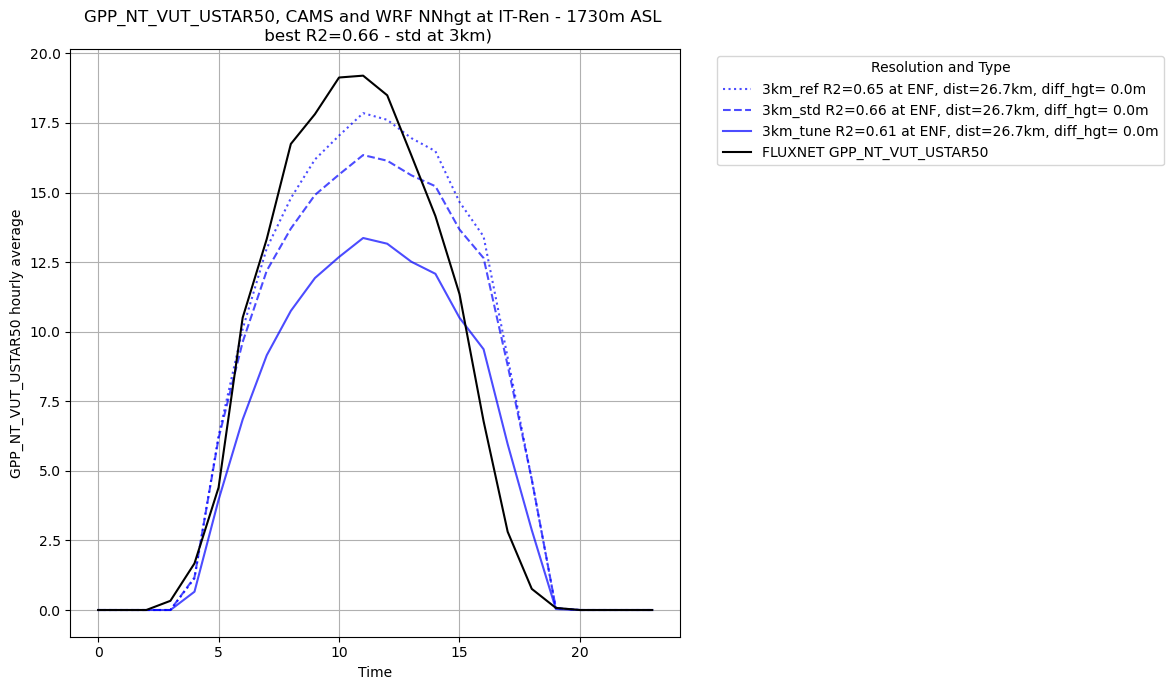

Filtered DataFrame shape: (1391, 237)


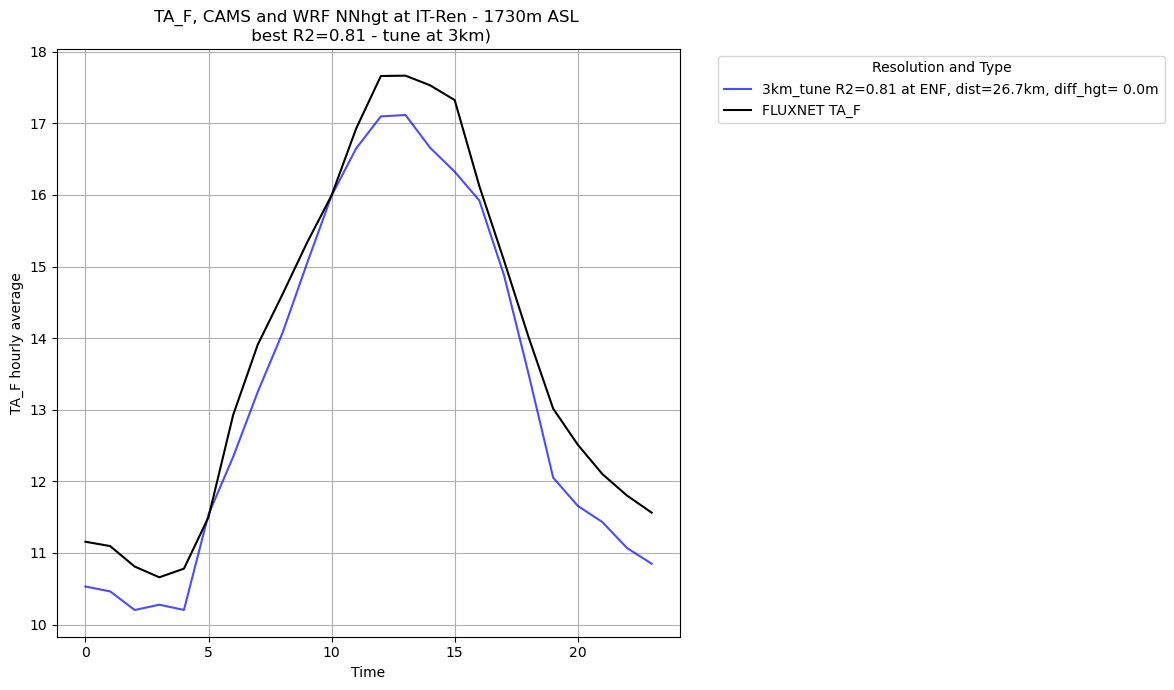

Filtered DataFrame shape: (1391, 237)


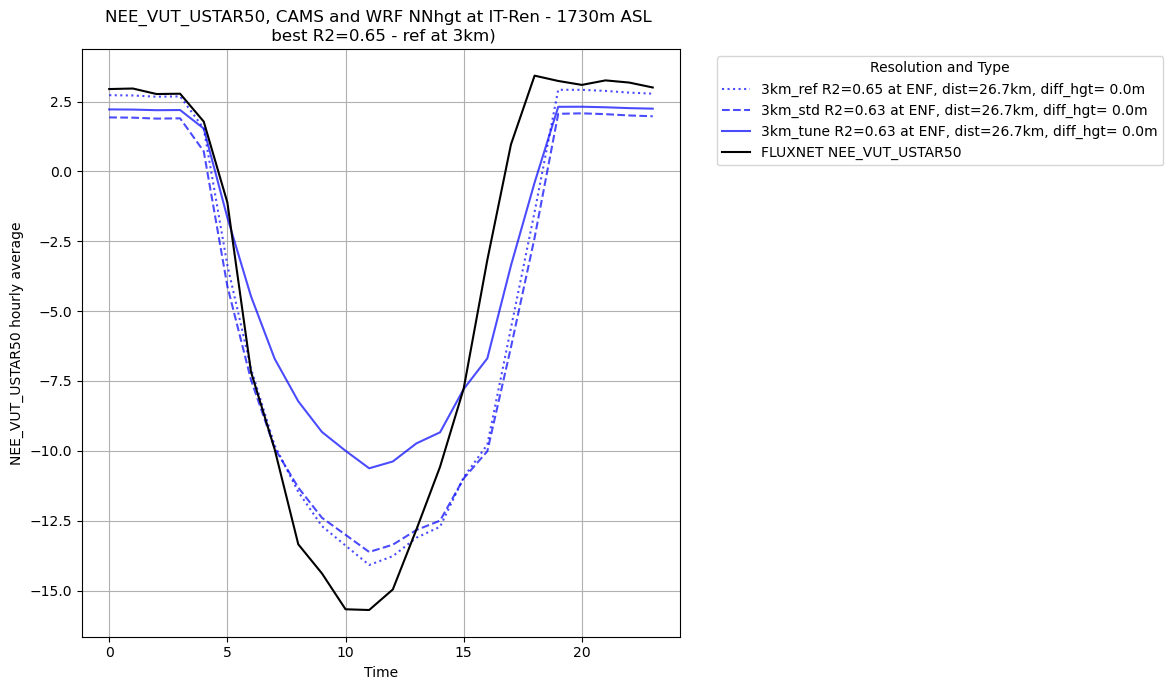

Filtered DataFrame shape: (1391, 237)


/tmp/ipykernel_1210108/1766289711.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loc["hour"] = df_loc.index.hour
/tmp/ipykernel_1210108/1766289711.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loc["hour"] = df_loc.index.hour
/tmp/ipykernel_1210108/1766289711.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

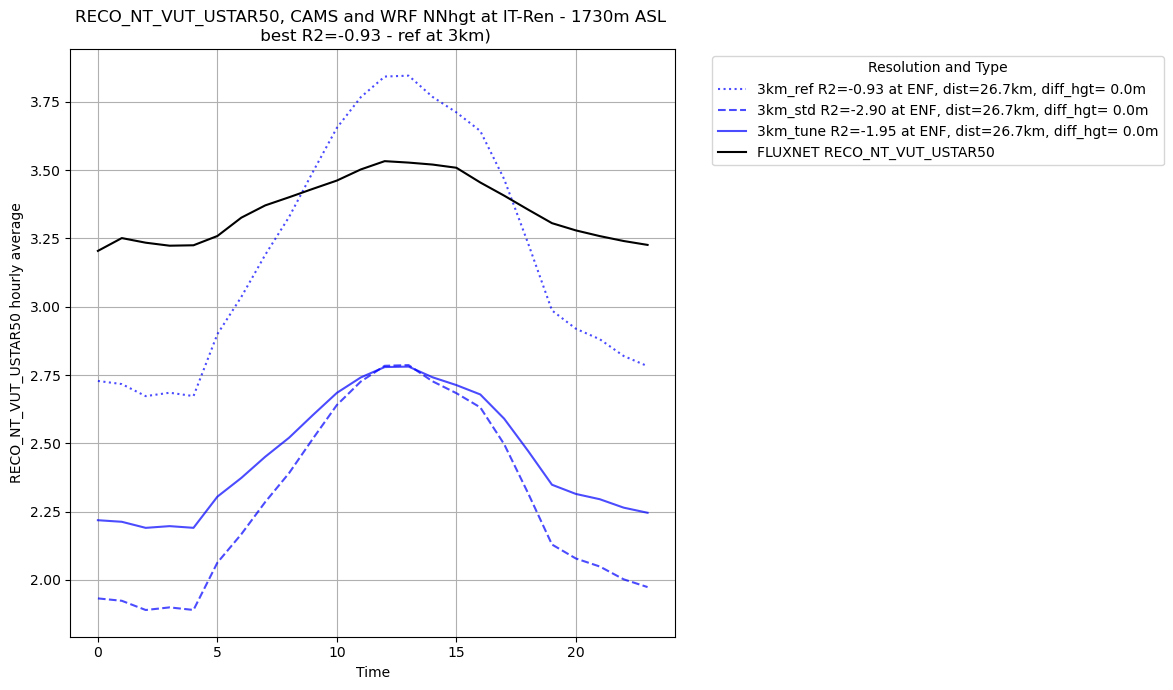

Filtered DataFrame shape: (1391, 232)


/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: divide by zero encountered in divide
  result = np.mean(np.abs(y_true - y_pred) / np.abs(y_true), axis=0)
/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: invalid value encountered in divide
  result = np.mean(np.abs(y_true - y_pred) / np.abs(y_true), axis=0)
/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: divide by zero encountered in divide
  result = np.mean(np.abs(y_true - y_pred) / np.abs(y_true), axis=0)
/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: invalid value encountered in divide
  result = np.mean(np.abs(y_true - y_pred) / np.abs(y_true), axis=0)
/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: divide by zer

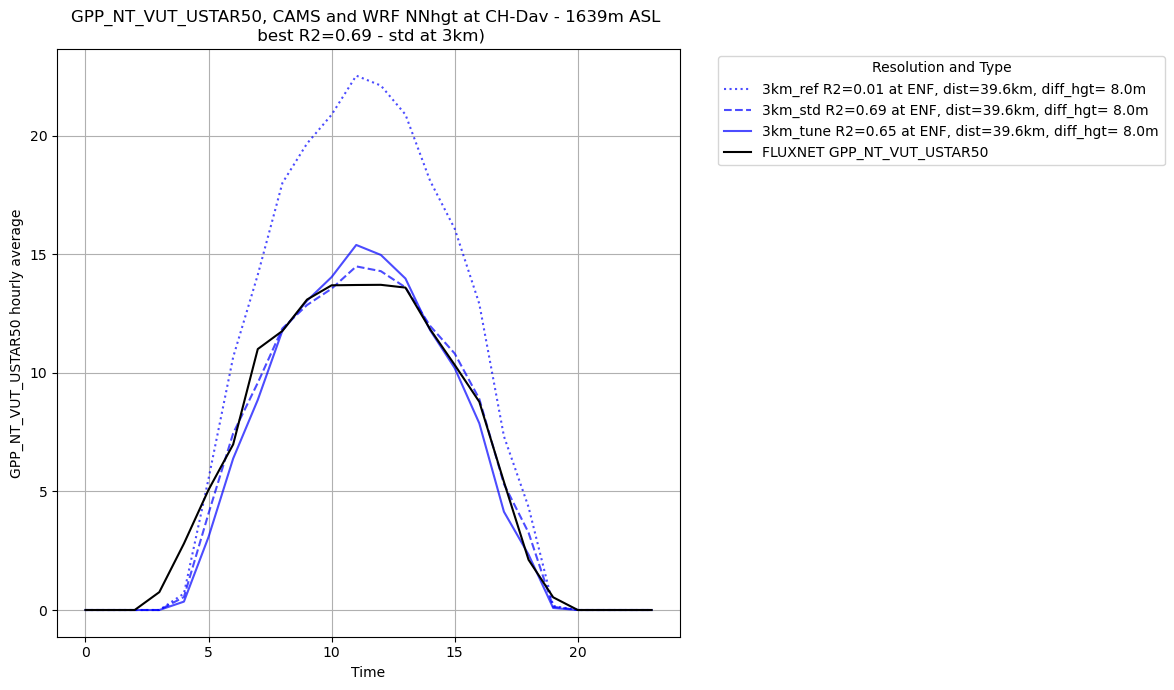

Filtered DataFrame shape: (1391, 232)


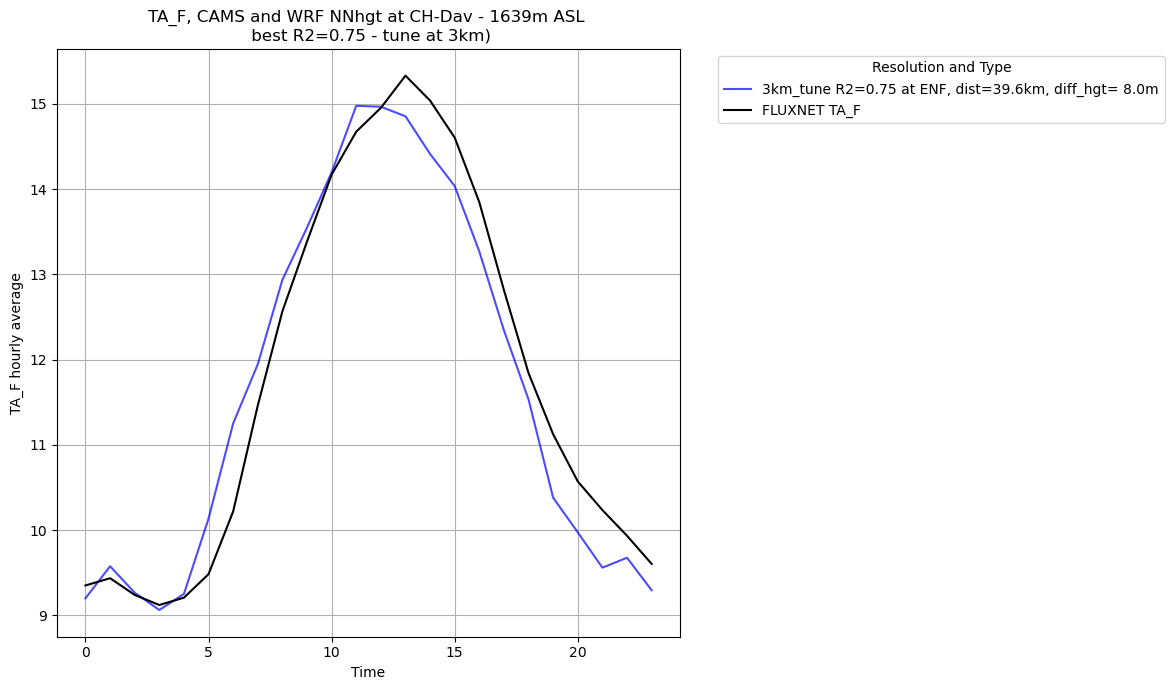

Filtered DataFrame shape: (1391, 232)


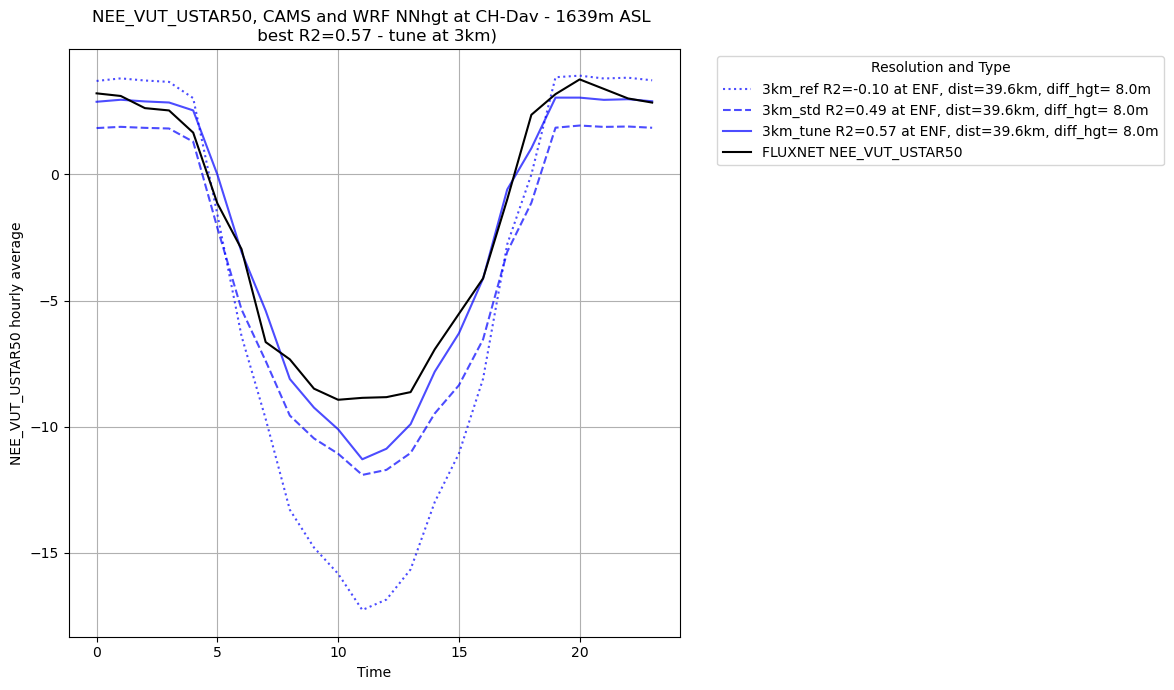

Filtered DataFrame shape: (1391, 232)


/tmp/ipykernel_1210108/1766289711.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loc["hour"] = df_loc.index.hour
/tmp/ipykernel_1210108/1766289711.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loc["hour"] = df_loc.index.hour
/tmp/ipykernel_1210108/1766289711.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

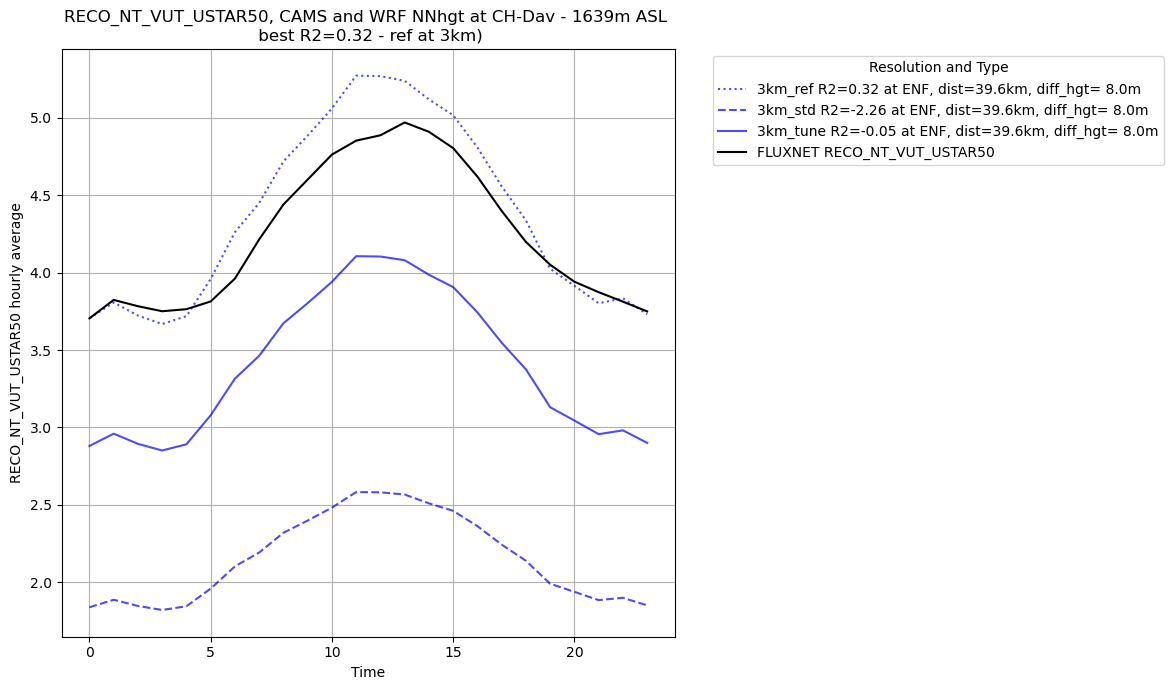

Filtered DataFrame shape: (1391, 240)


/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: divide by zero encountered in divide
  result = np.mean(np.abs(y_true - y_pred) / np.abs(y_true), axis=0)
/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: invalid value encountered in divide
  result = np.mean(np.abs(y_true - y_pred) / np.abs(y_true), axis=0)
/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: divide by zero encountered in divide
  result = np.mean(np.abs(y_true - y_pred) / np.abs(y_true), axis=0)
/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: invalid value encountered in divide
  result = np.mean(np.abs(y_true - y_pred) / np.abs(y_true), axis=0)
/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: divide by zer

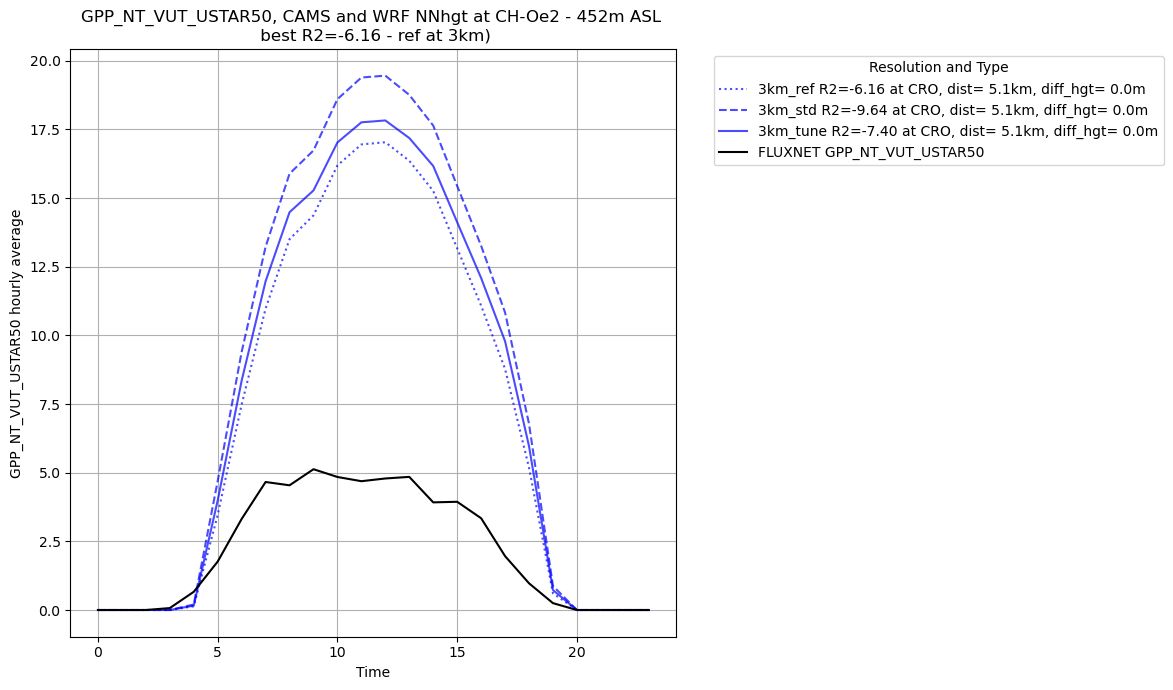

Filtered DataFrame shape: (1391, 240)


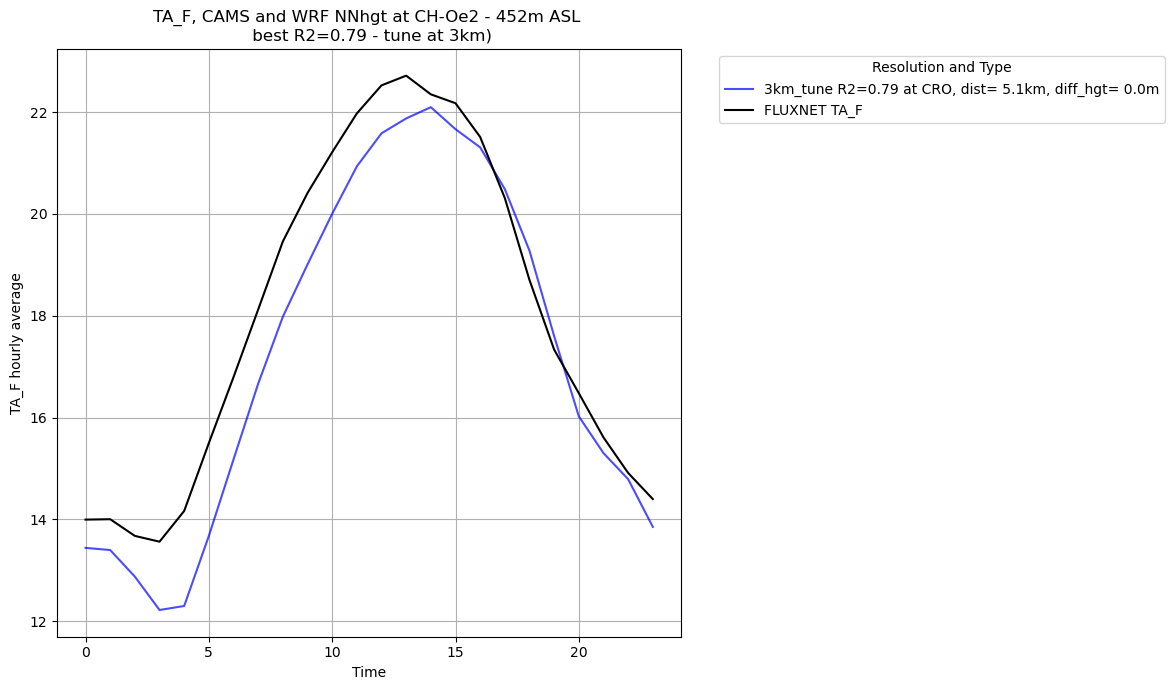

Filtered DataFrame shape: (1391, 240)


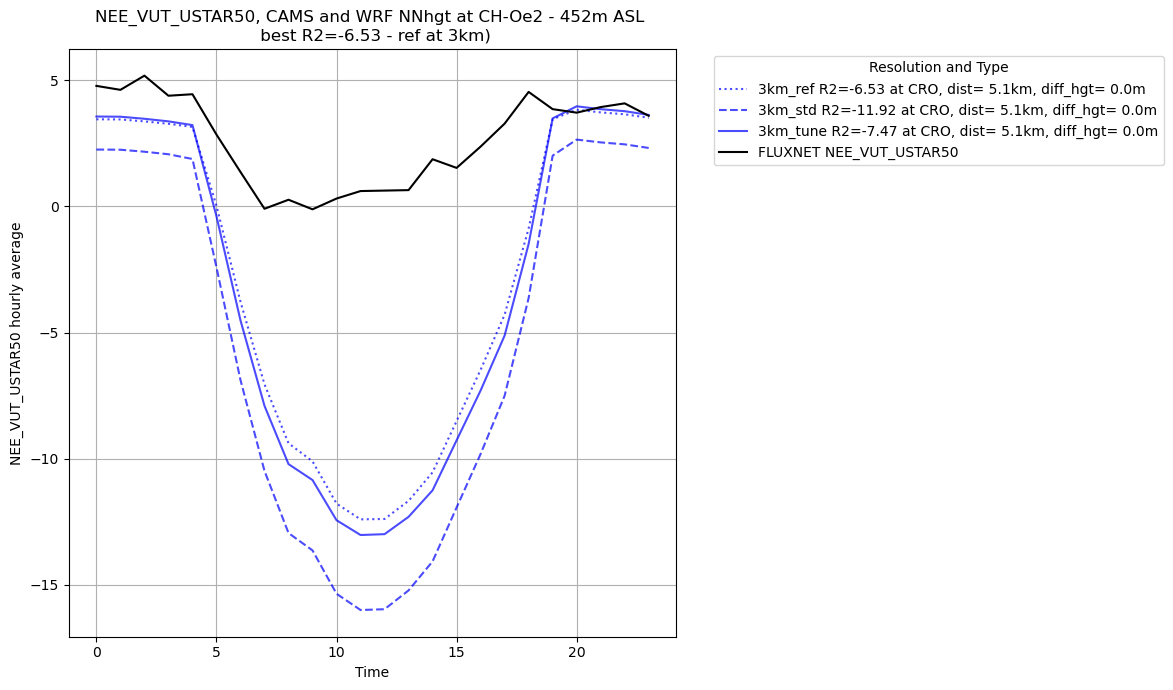

Filtered DataFrame shape: (1391, 240)


/tmp/ipykernel_1210108/1766289711.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loc["hour"] = df_loc.index.hour
/tmp/ipykernel_1210108/1766289711.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loc["hour"] = df_loc.index.hour
/tmp/ipykernel_1210108/1766289711.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

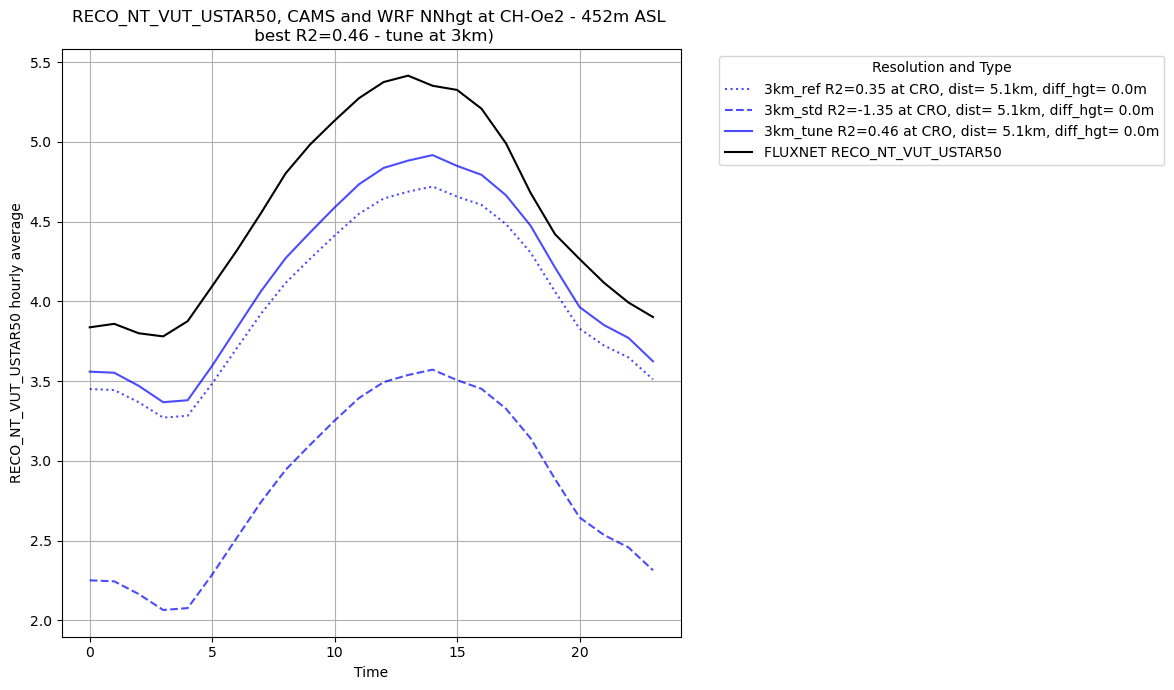

Filtered DataFrame shape: (1391, 224)


/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: divide by zero encountered in divide
  result = np.mean(np.abs(y_true - y_pred) / np.abs(y_true), axis=0)
/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: invalid value encountered in divide
  result = np.mean(np.abs(y_true - y_pred) / np.abs(y_true), axis=0)
/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: divide by zero encountered in divide
  result = np.mean(np.abs(y_true - y_pred) / np.abs(y_true), axis=0)
/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: invalid value encountered in divide
  result = np.mean(np.abs(y_true - y_pred) / np.abs(y_true), axis=0)
/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: divide by zer

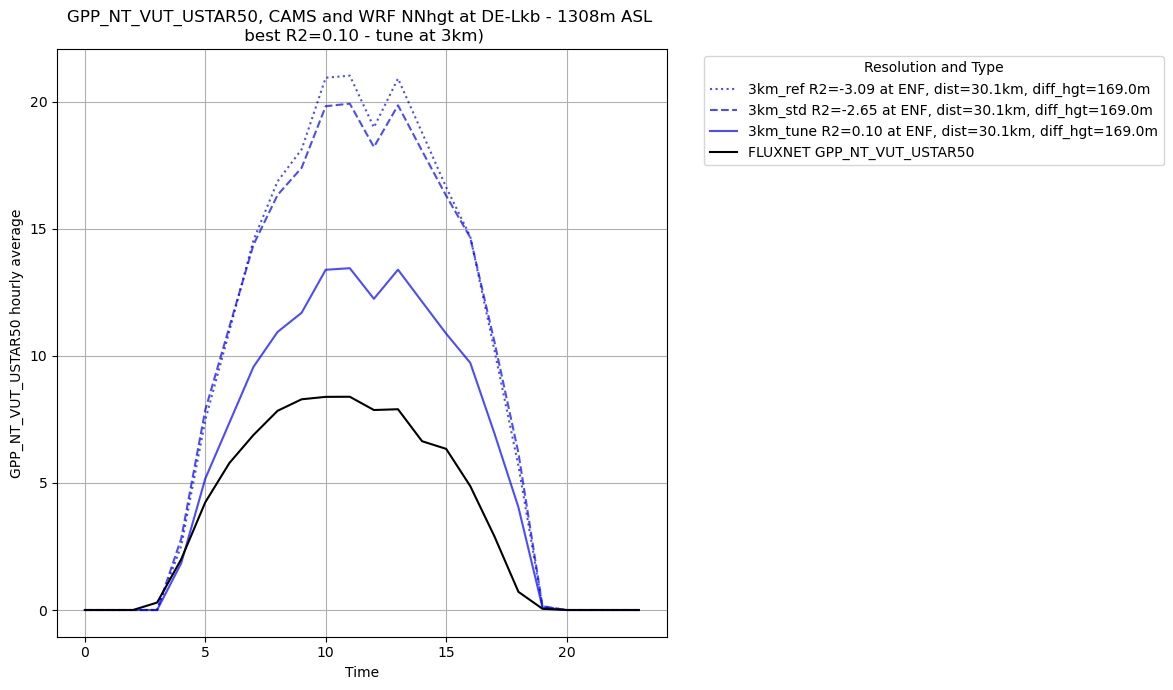

Filtered DataFrame shape: (1391, 224)


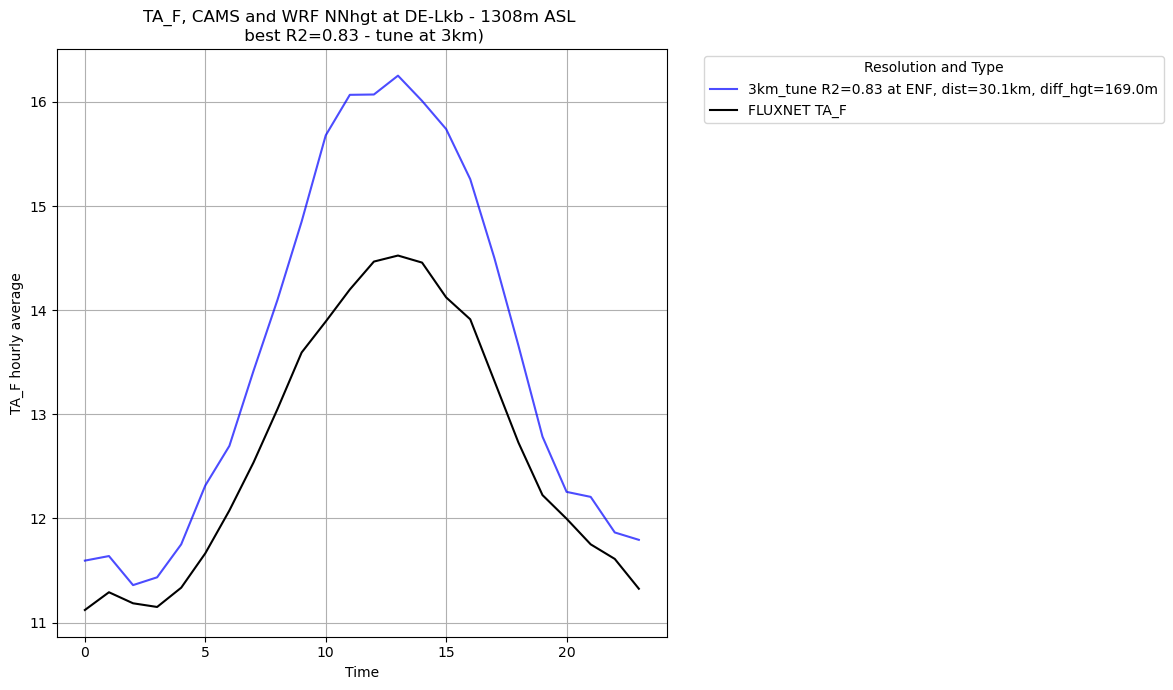

Filtered DataFrame shape: (1391, 224)


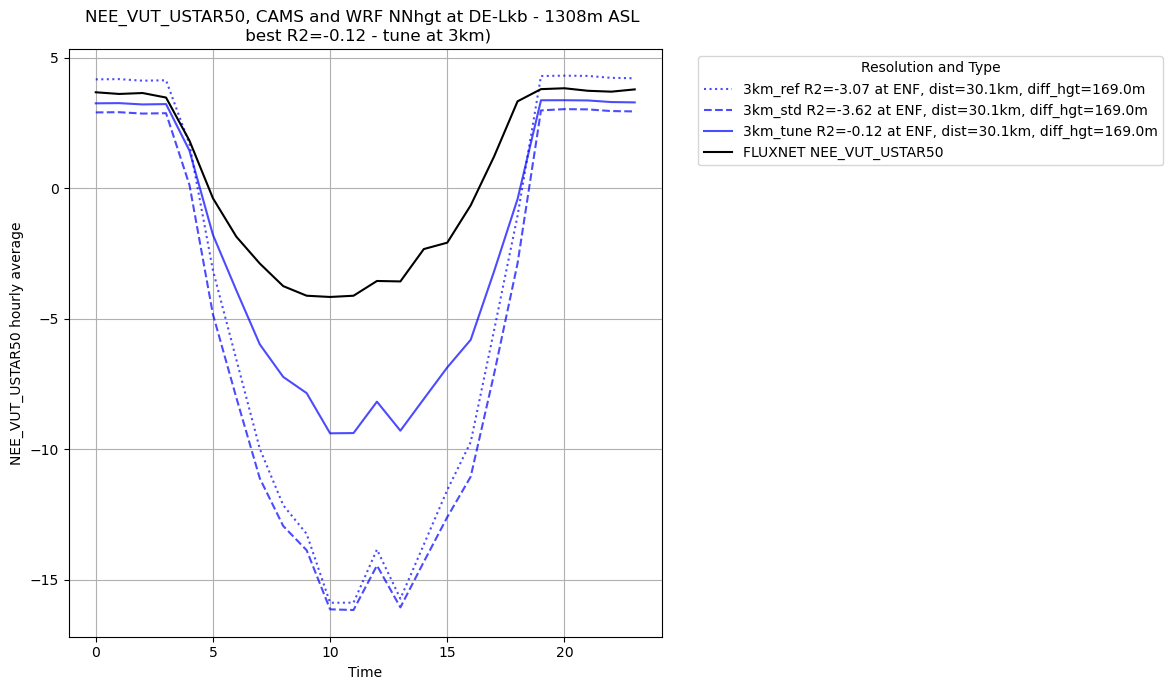

Filtered DataFrame shape: (1391, 224)


/tmp/ipykernel_1210108/1766289711.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loc["hour"] = df_loc.index.hour
/tmp/ipykernel_1210108/1766289711.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loc["hour"] = df_loc.index.hour
/tmp/ipykernel_1210108/1766289711.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

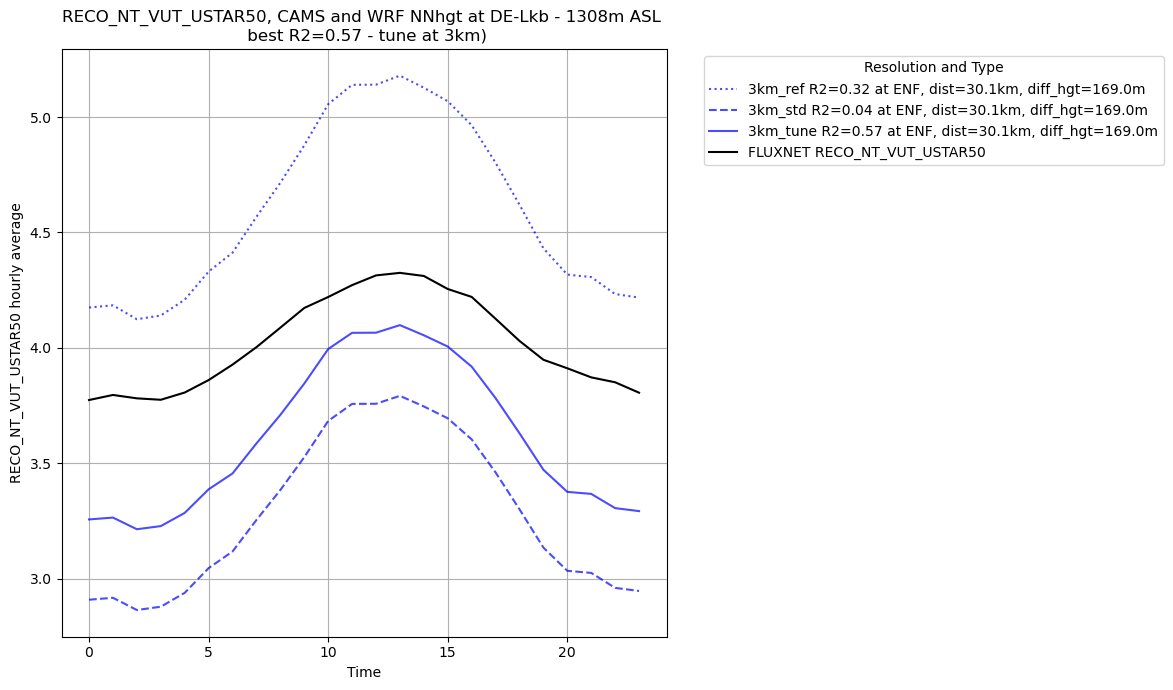

Filtered DataFrame shape: (1391, 232)


/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: divide by zero encountered in divide
  result = np.mean(np.abs(y_true - y_pred) / np.abs(y_true), axis=0)
/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: invalid value encountered in divide
  result = np.mean(np.abs(y_true - y_pred) / np.abs(y_true), axis=0)
/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: divide by zero encountered in divide
  result = np.mean(np.abs(y_true - y_pred) / np.abs(y_true), axis=0)
/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: invalid value encountered in divide
  result = np.mean(np.abs(y_true - y_pred) / np.abs(y_true), axis=0)
/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: divide by zer

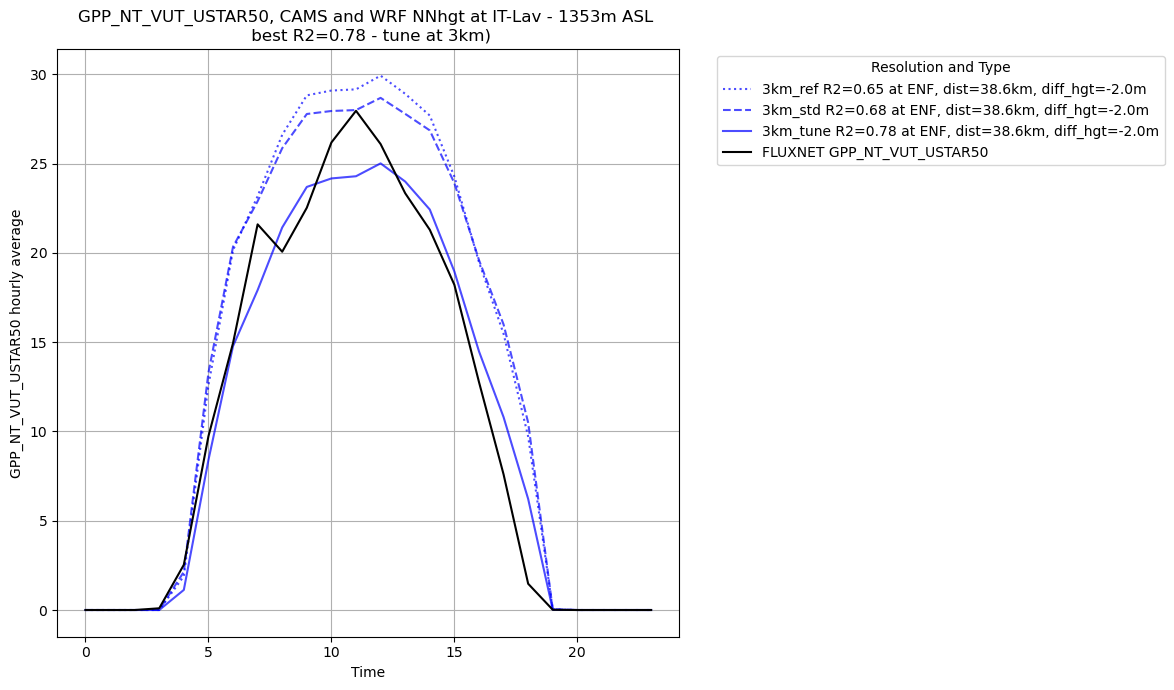

Filtered DataFrame shape: (1391, 232)


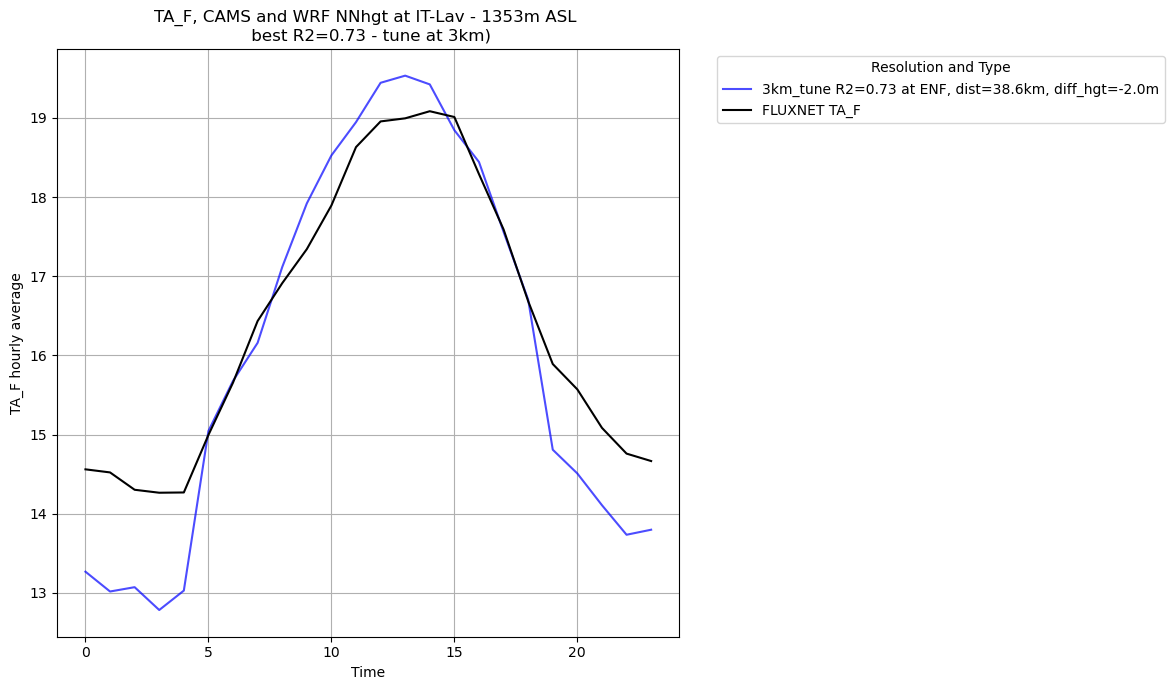

Filtered DataFrame shape: (1391, 232)


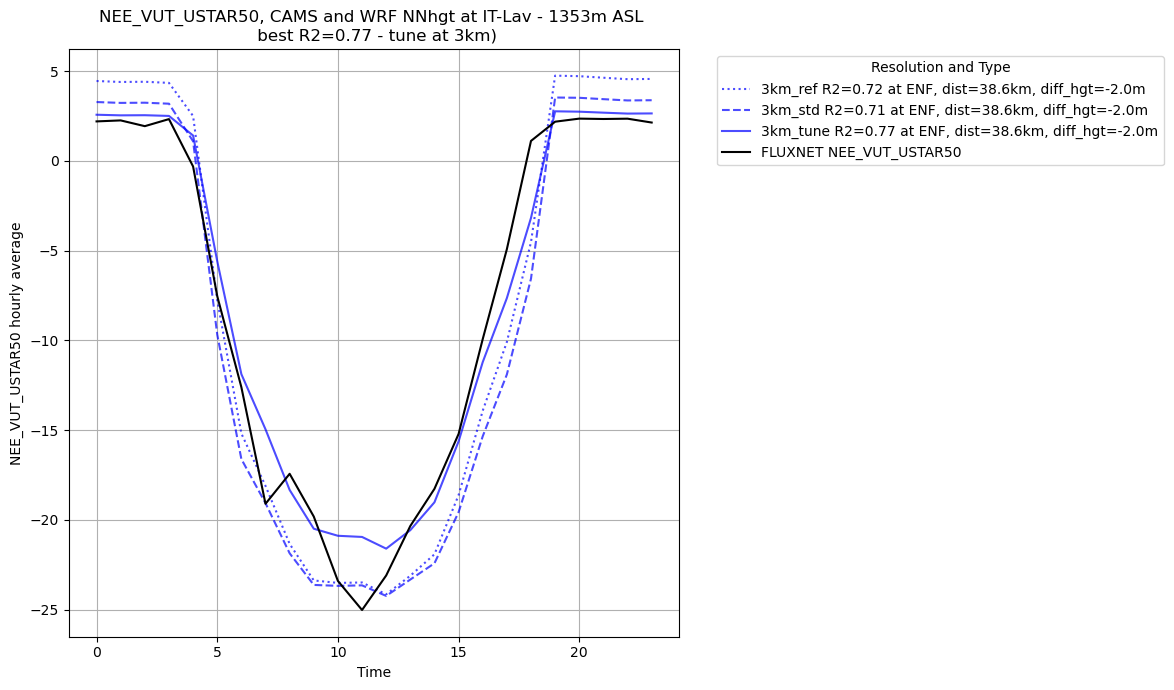

Filtered DataFrame shape: (1391, 232)


/tmp/ipykernel_1210108/1766289711.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loc["hour"] = df_loc.index.hour
/tmp/ipykernel_1210108/1766289711.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loc["hour"] = df_loc.index.hour
/tmp/ipykernel_1210108/1766289711.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

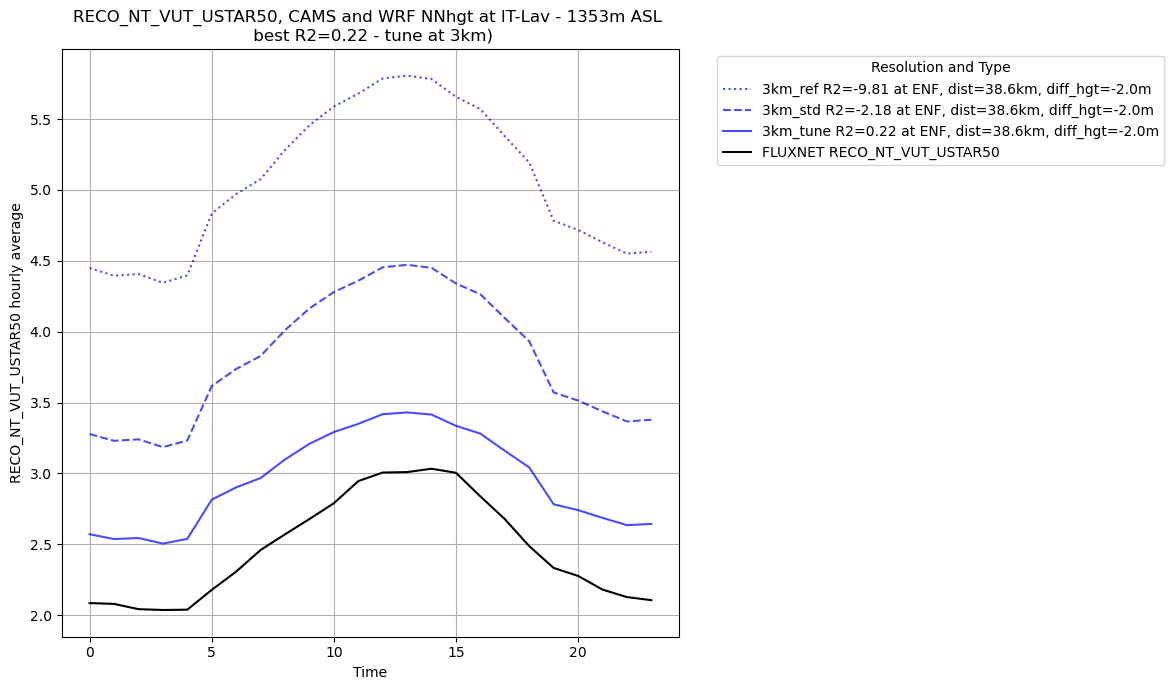

Filtered DataFrame shape: (1391, 234)


/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: divide by zero encountered in divide
  result = np.mean(np.abs(y_true - y_pred) / np.abs(y_true), axis=0)
/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: invalid value encountered in divide
  result = np.mean(np.abs(y_true - y_pred) / np.abs(y_true), axis=0)
/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: divide by zero encountered in divide
  result = np.mean(np.abs(y_true - y_pred) / np.abs(y_true), axis=0)
/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: invalid value encountered in divide
  result = np.mean(np.abs(y_true - y_pred) / np.abs(y_true), axis=0)
/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: divide by zer

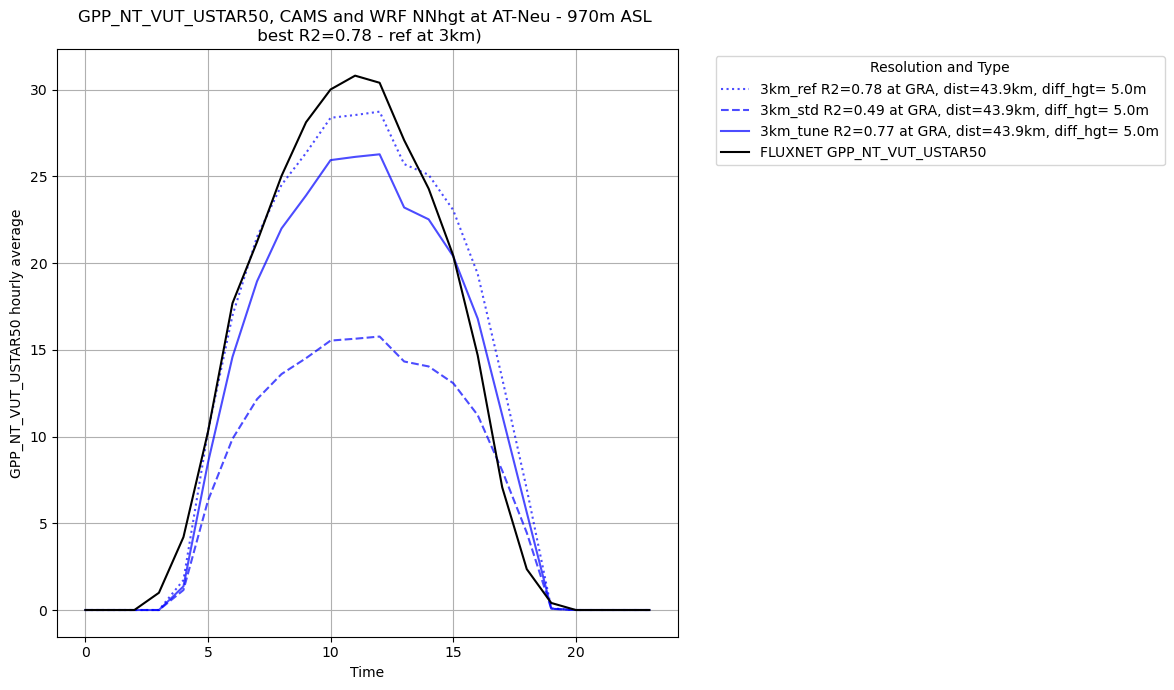

Filtered DataFrame shape: (1391, 234)


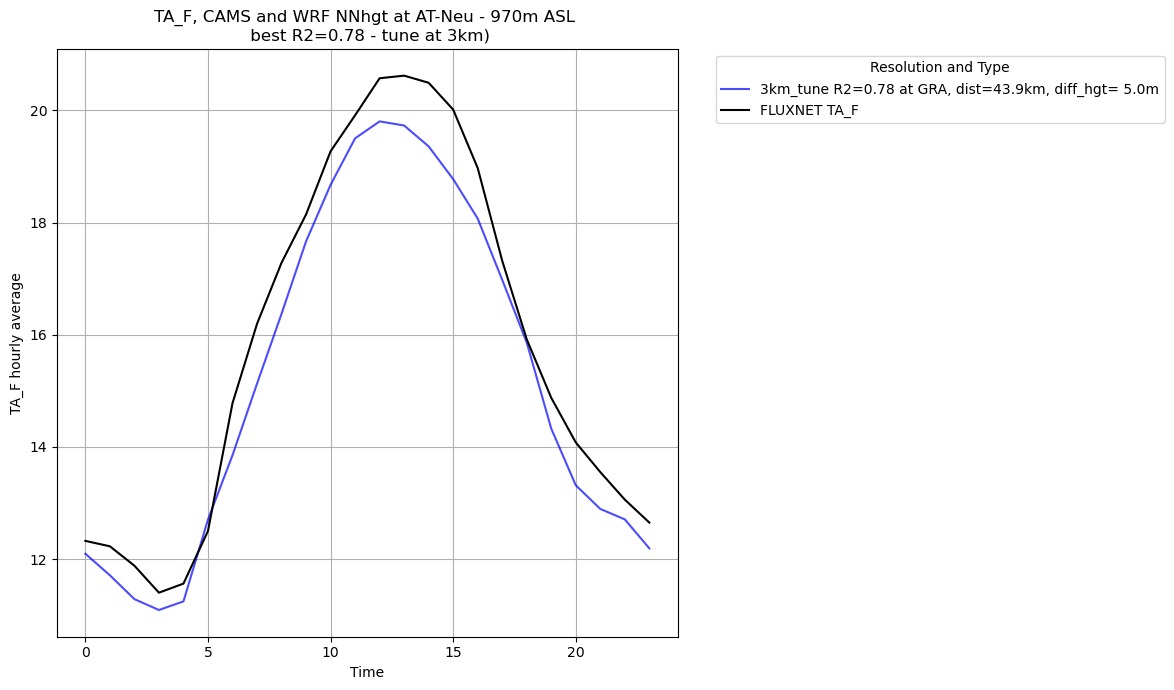

Filtered DataFrame shape: (1391, 234)


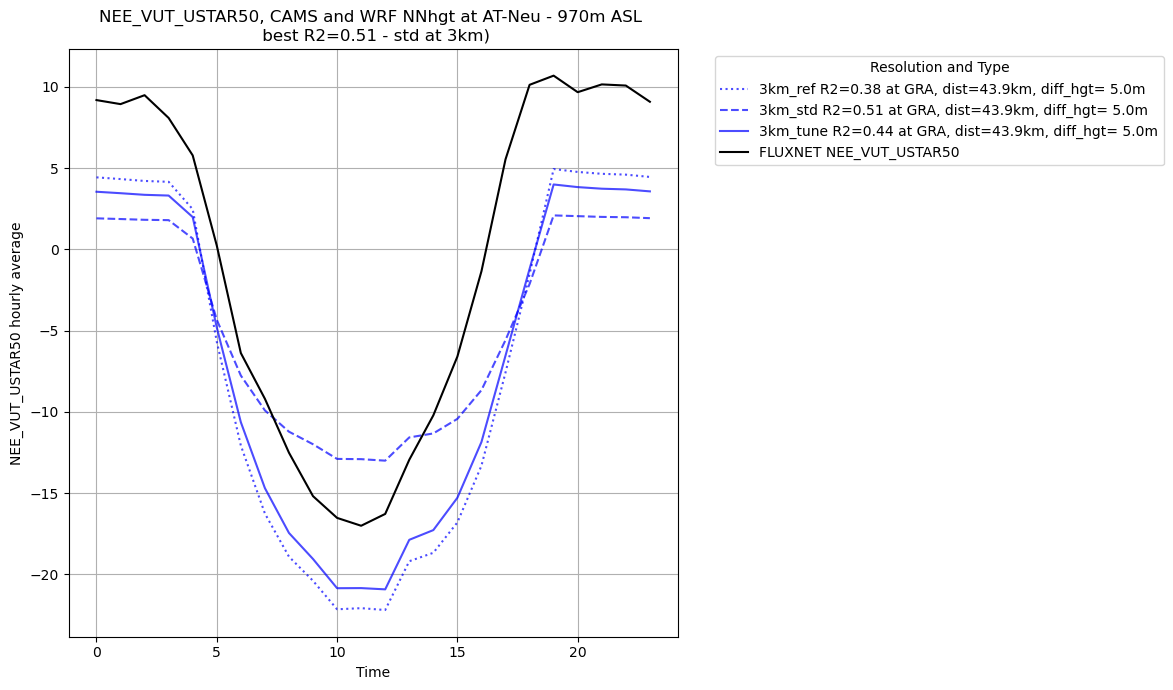

Filtered DataFrame shape: (1391, 234)


/tmp/ipykernel_1210108/1766289711.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loc["hour"] = df_loc.index.hour
/tmp/ipykernel_1210108/1766289711.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loc["hour"] = df_loc.index.hour
/tmp/ipykernel_1210108/1766289711.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

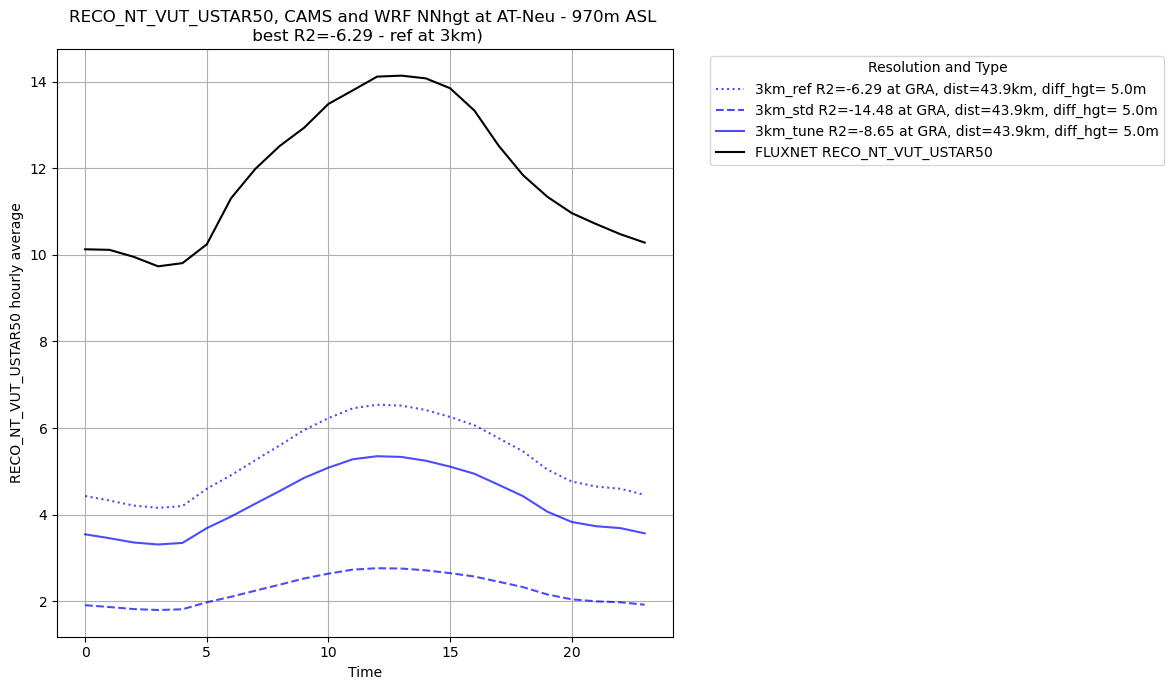

Filtered DataFrame shape: (1391, 231)


/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: divide by zero encountered in divide
  result = np.mean(np.abs(y_true - y_pred) / np.abs(y_true), axis=0)
/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: invalid value encountered in divide
  result = np.mean(np.abs(y_true - y_pred) / np.abs(y_true), axis=0)
/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: divide by zero encountered in divide
  result = np.mean(np.abs(y_true - y_pred) / np.abs(y_true), axis=0)
/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: invalid value encountered in divide
  result = np.mean(np.abs(y_true - y_pred) / np.abs(y_true), axis=0)
/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: divide by zer

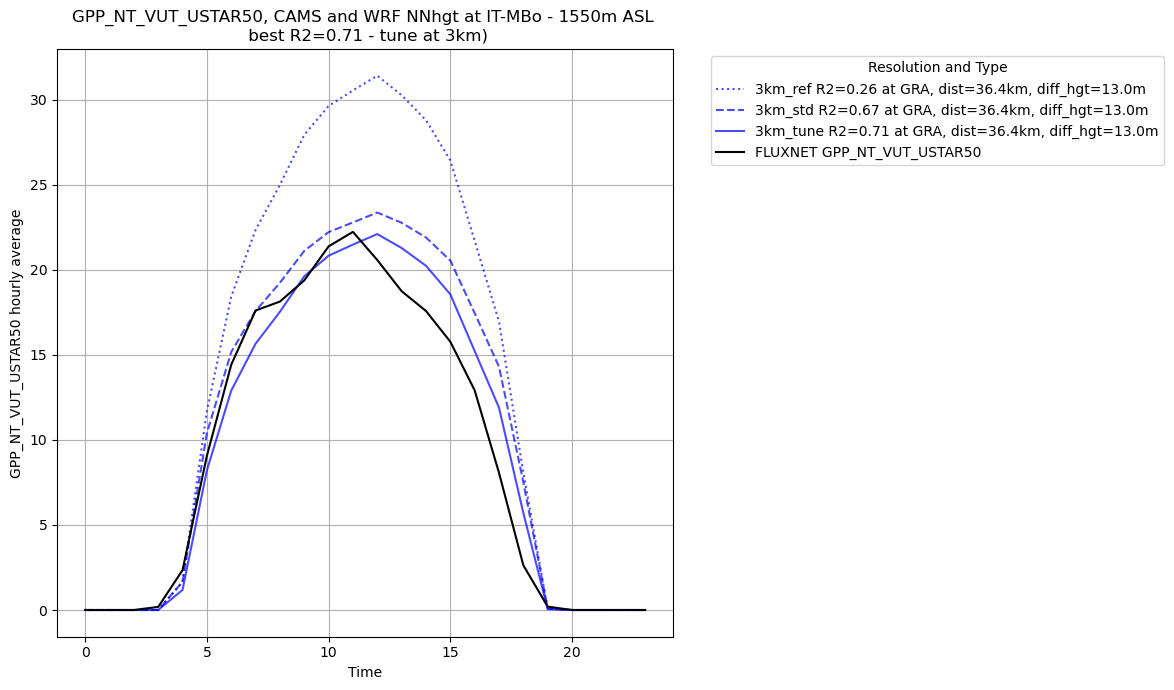

Filtered DataFrame shape: (1391, 231)


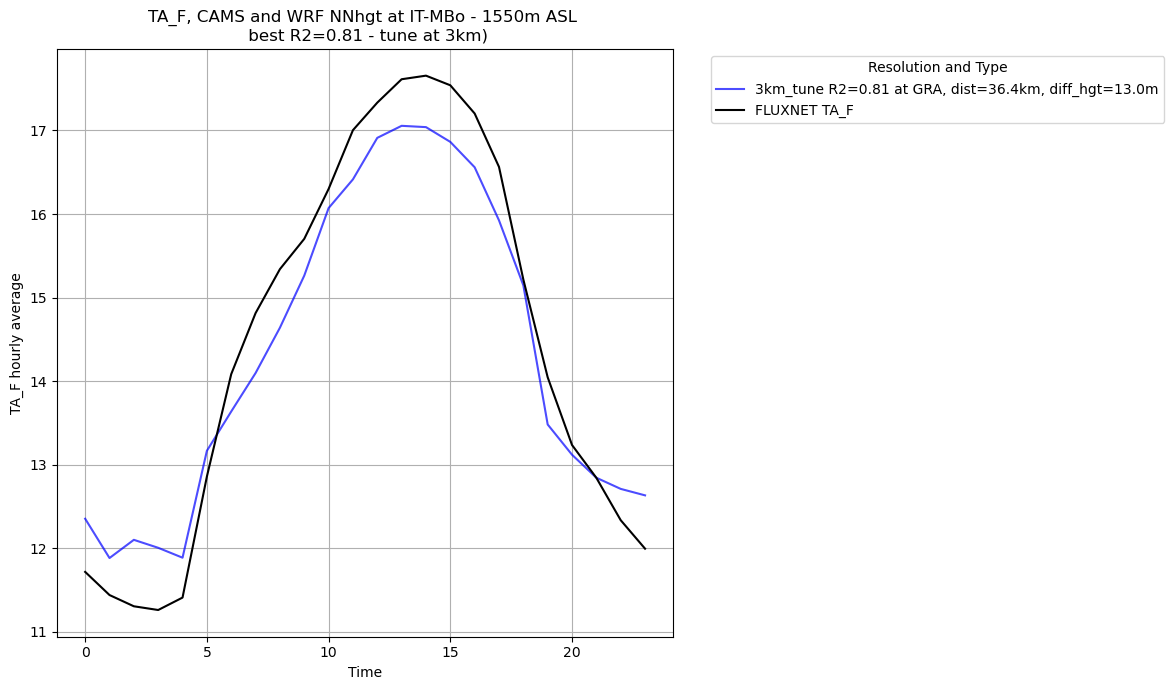

Filtered DataFrame shape: (1391, 231)


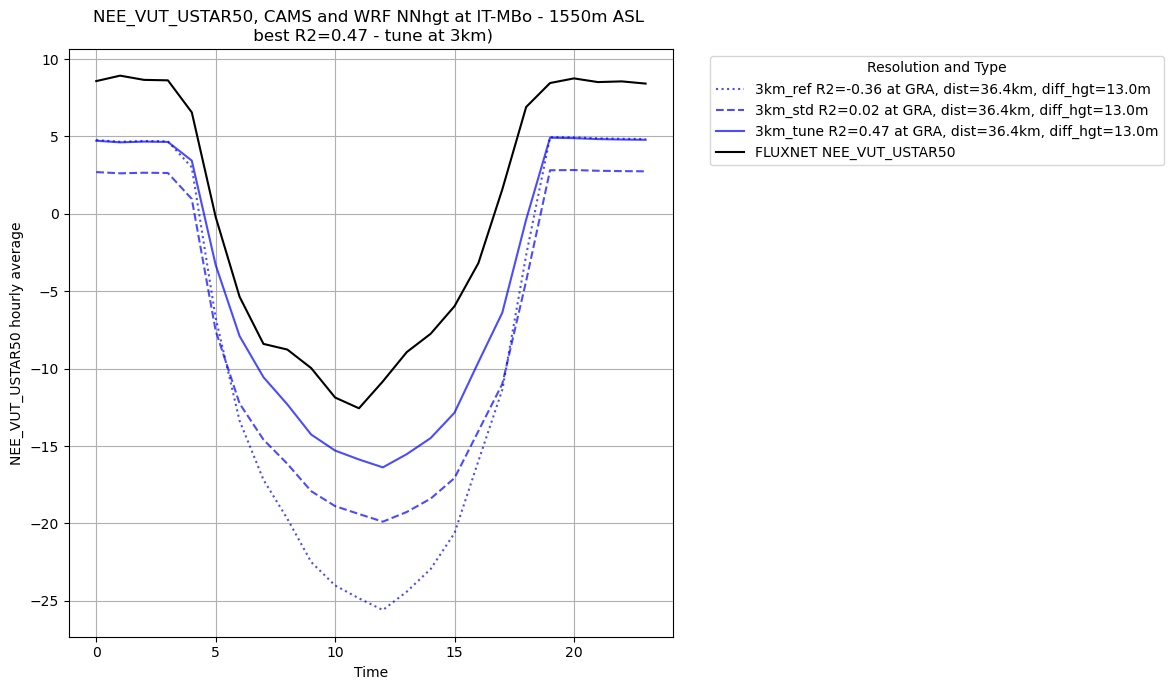

Filtered DataFrame shape: (1391, 231)


/tmp/ipykernel_1210108/1766289711.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loc["hour"] = df_loc.index.hour
/tmp/ipykernel_1210108/1766289711.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loc["hour"] = df_loc.index.hour
/tmp/ipykernel_1210108/1766289711.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

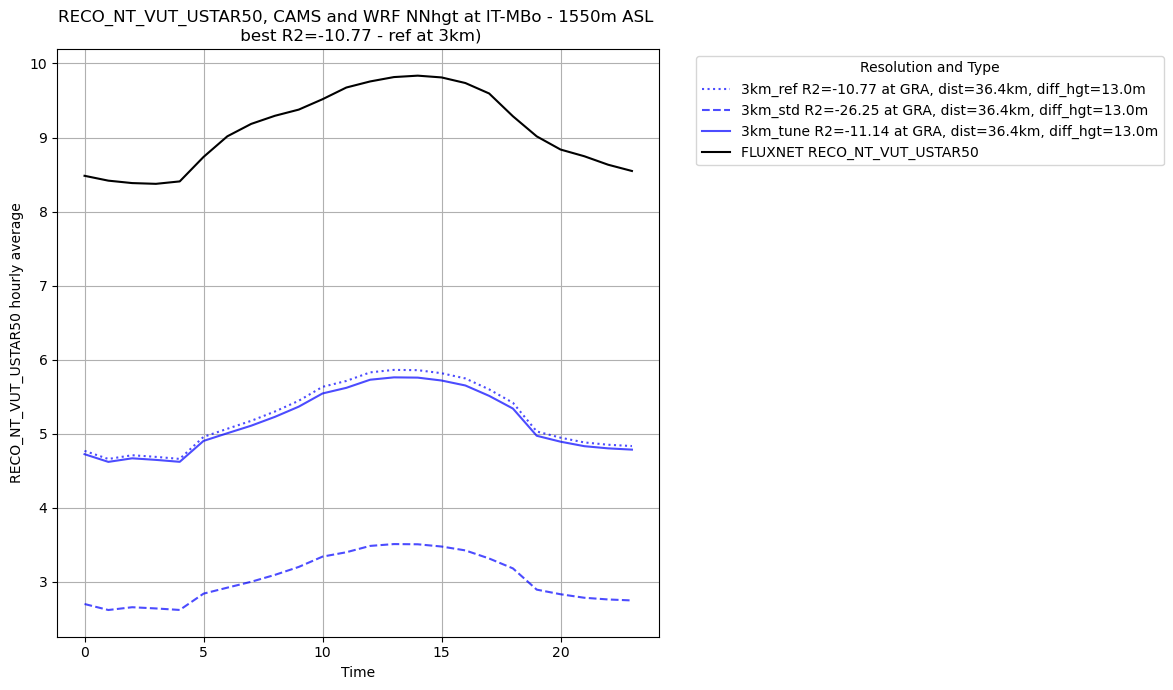

Filtered DataFrame shape: (1391, 230)


/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: divide by zero encountered in divide
  result = np.mean(np.abs(y_true - y_pred) / np.abs(y_true), axis=0)
/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: invalid value encountered in divide
  result = np.mean(np.abs(y_true - y_pred) / np.abs(y_true), axis=0)
/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: divide by zero encountered in divide
  result = np.mean(np.abs(y_true - y_pred) / np.abs(y_true), axis=0)
/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: invalid value encountered in divide
  result = np.mean(np.abs(y_true - y_pred) / np.abs(y_true), axis=0)
/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: divide by zer

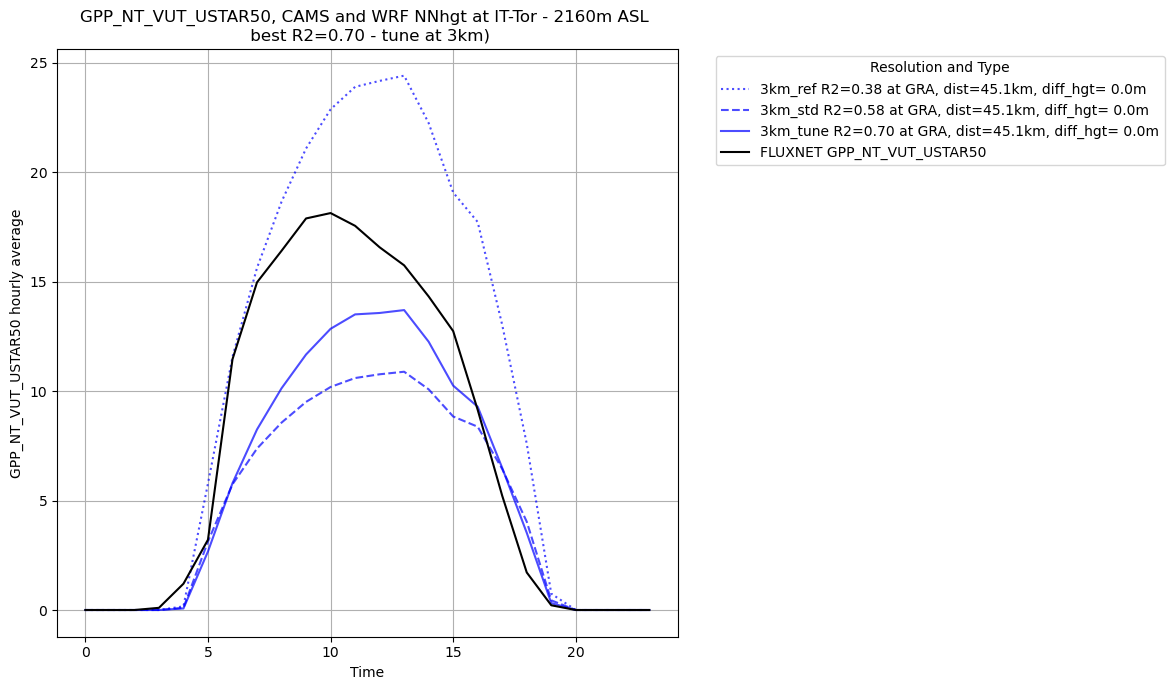

Filtered DataFrame shape: (1391, 230)


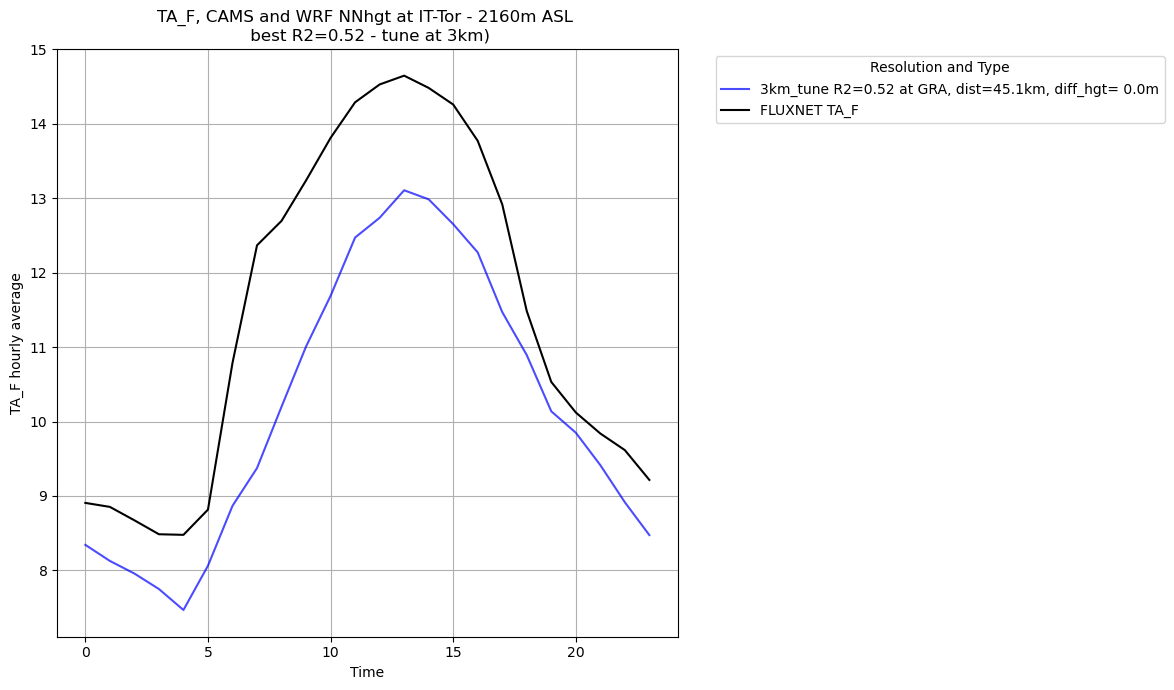

Filtered DataFrame shape: (1391, 230)


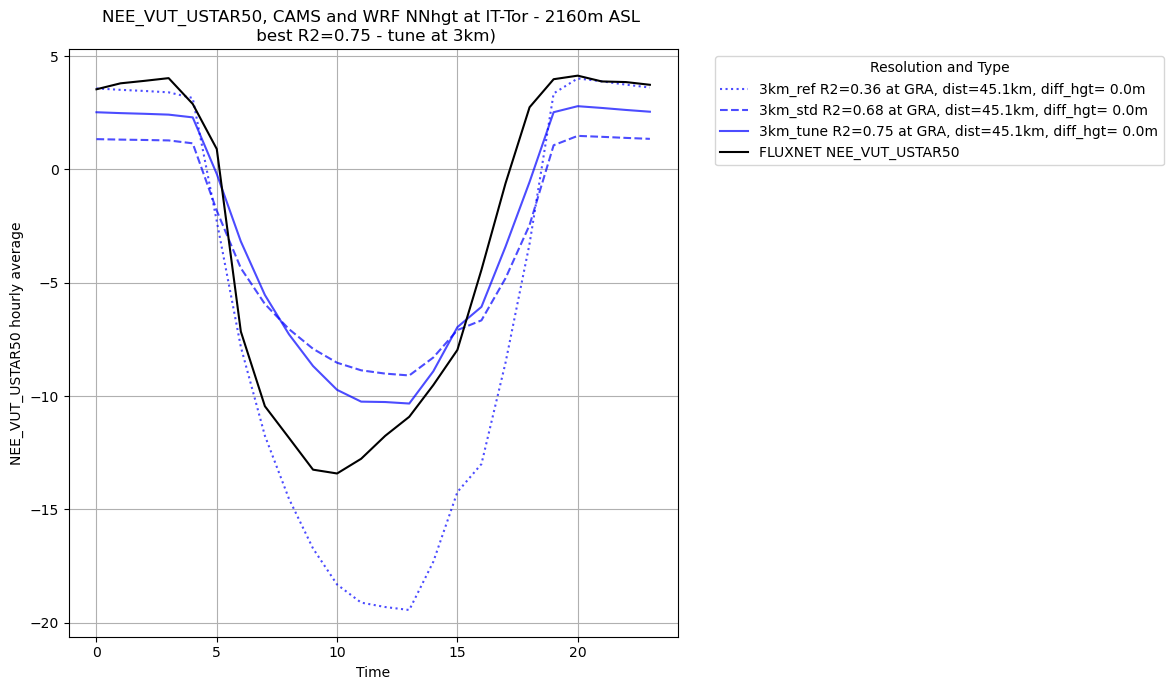

Filtered DataFrame shape: (1391, 230)


/tmp/ipykernel_1210108/1766289711.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loc["hour"] = df_loc.index.hour
/tmp/ipykernel_1210108/1766289711.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loc["hour"] = df_loc.index.hour
/tmp/ipykernel_1210108/1766289711.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

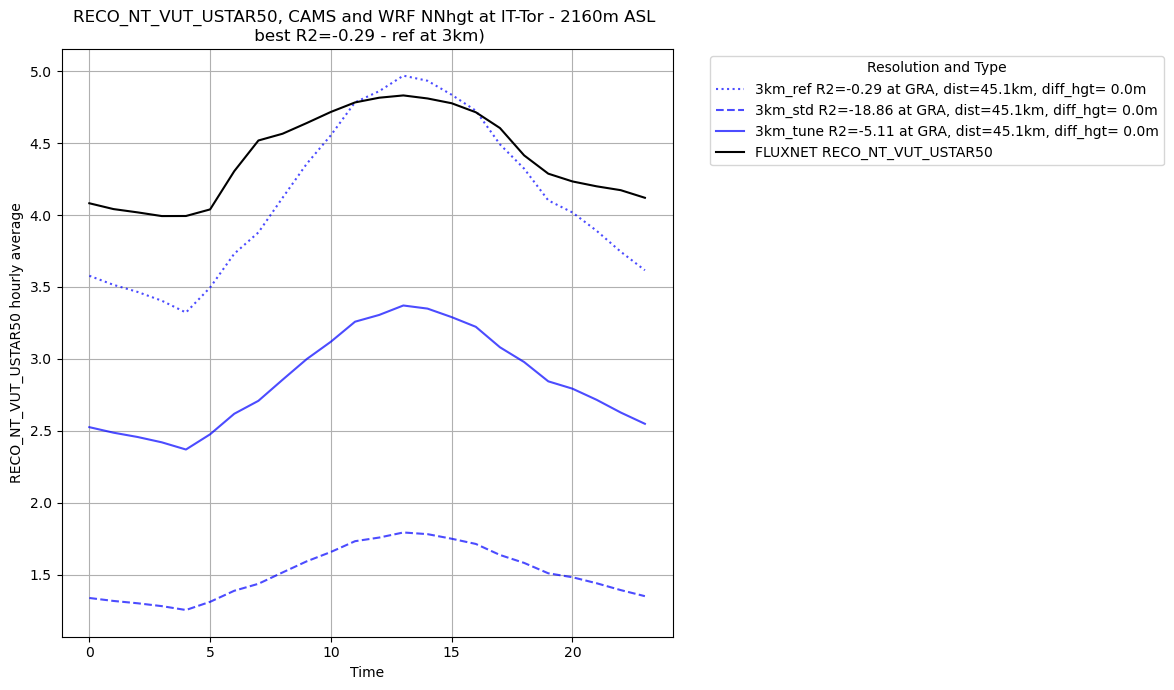

Filtered DataFrame shape: (1391, 235)


/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: divide by zero encountered in divide
  result = np.mean(np.abs(y_true - y_pred) / np.abs(y_true), axis=0)
/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: invalid value encountered in divide
  result = np.mean(np.abs(y_true - y_pred) / np.abs(y_true), axis=0)
/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: divide by zero encountered in divide
  result = np.mean(np.abs(y_true - y_pred) / np.abs(y_true), axis=0)
/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: invalid value encountered in divide
  result = np.mean(np.abs(y_true - y_pred) / np.abs(y_true), axis=0)
/scratch/c7071034/conda_envs/py_basic/lib/python3.12/site-packages/permetrics/regression.py:335: RuntimeWarning: divide by zer

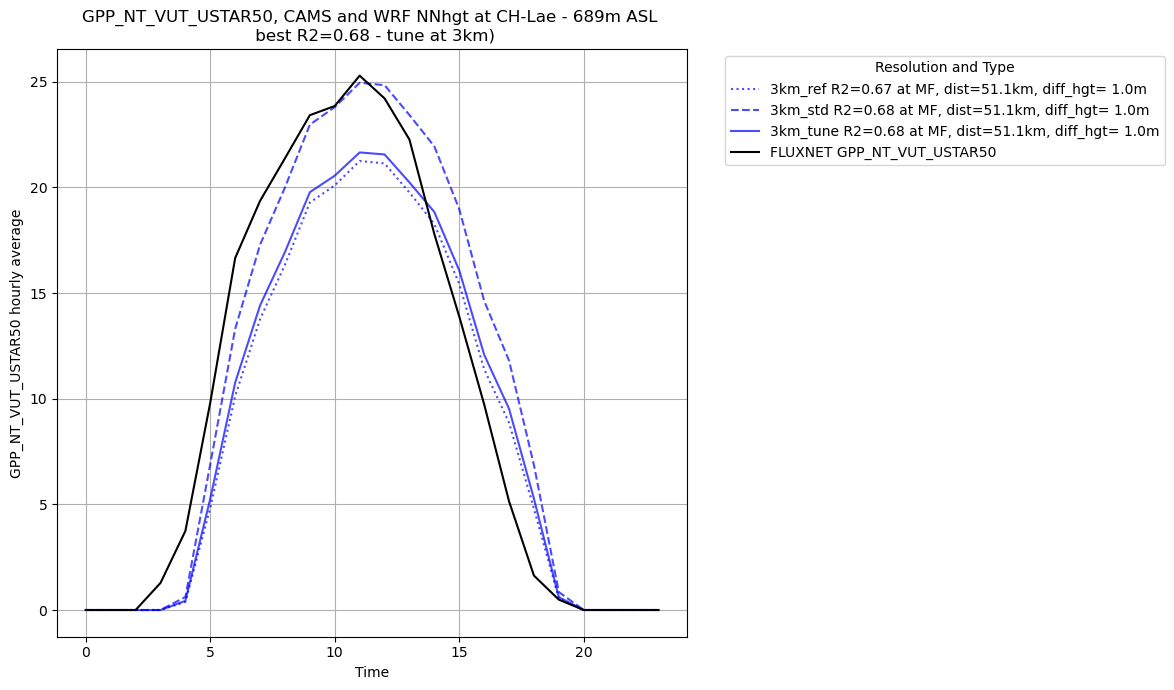

Filtered DataFrame shape: (1391, 235)


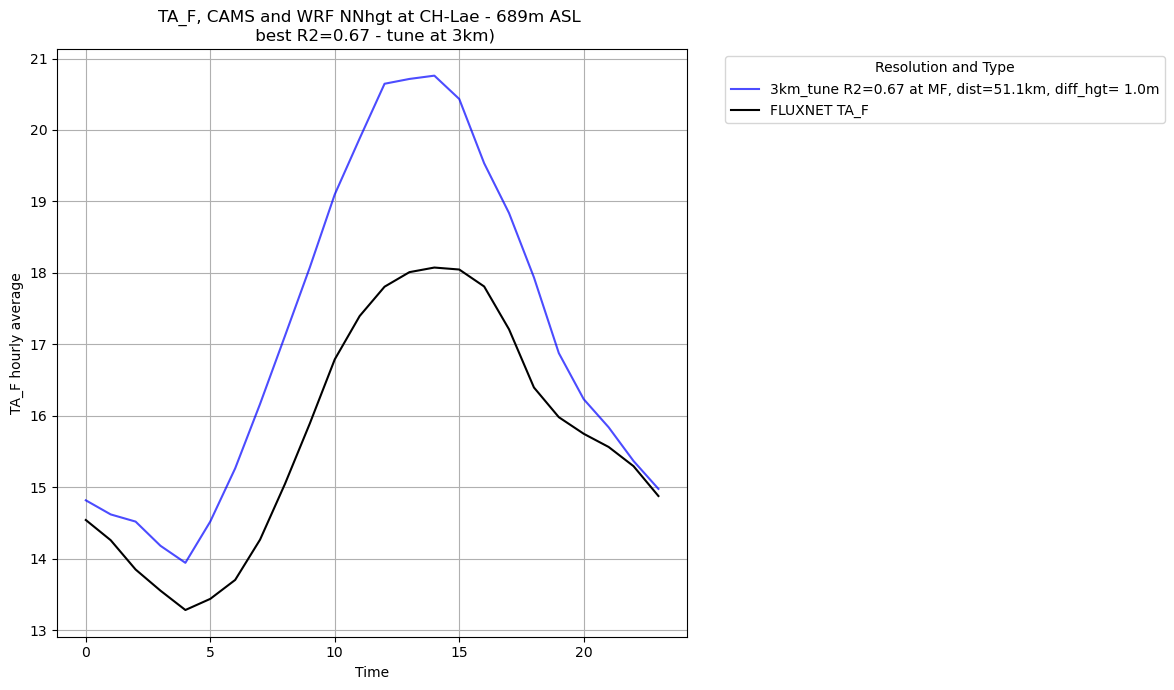

Filtered DataFrame shape: (1391, 235)


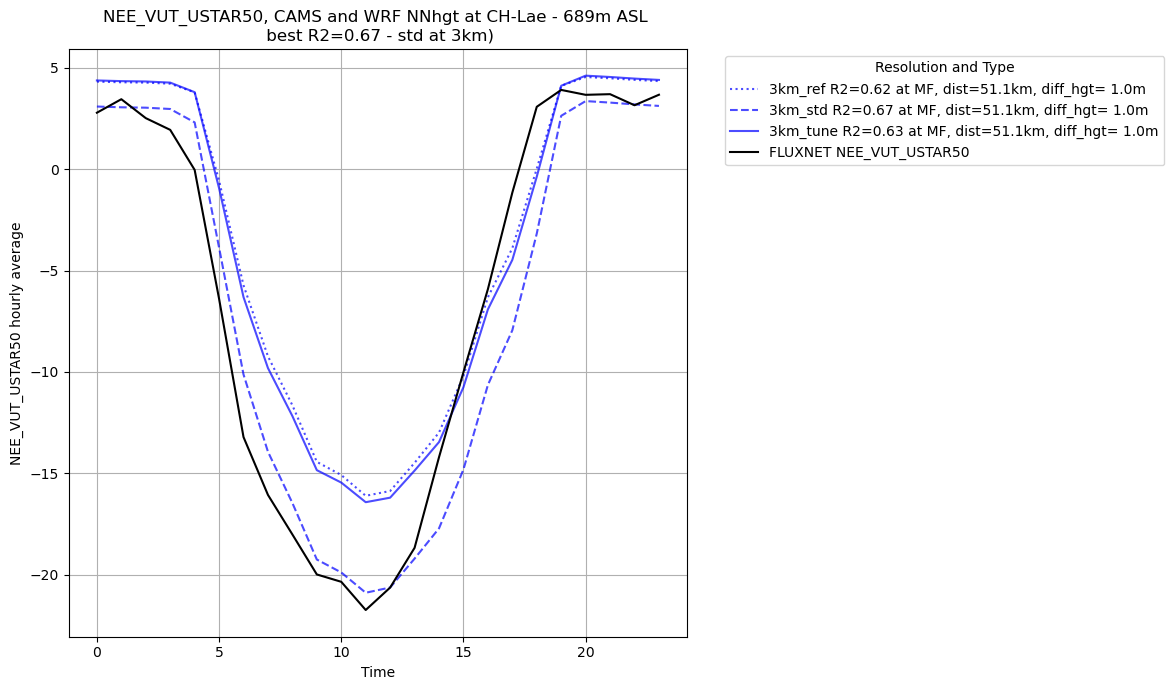

Filtered DataFrame shape: (1391, 235)


/tmp/ipykernel_1210108/1766289711.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loc["hour"] = df_loc.index.hour
/tmp/ipykernel_1210108/1766289711.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loc["hour"] = df_loc.index.hour
/tmp/ipykernel_1210108/1766289711.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

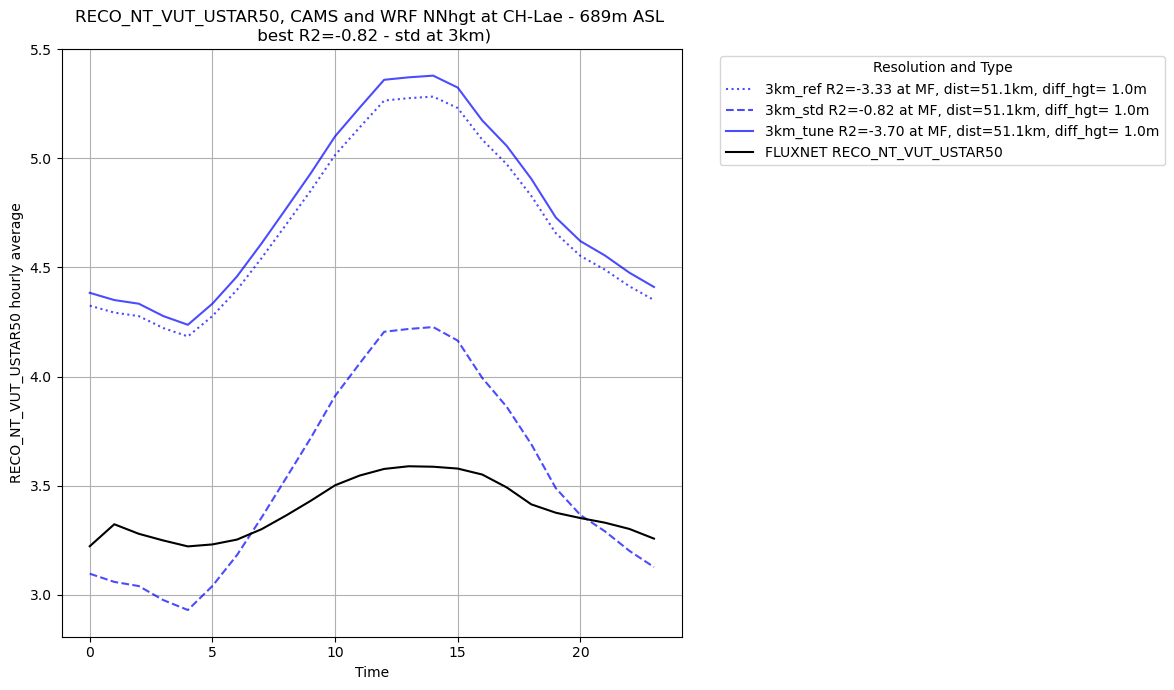

In [8]:

site_match_all = pd.read_csv(f"pft_site_match_at_{resolution}.csv")
# Create plots for each location
consolidated_metrics_all = pd.DataFrame()
for location in locations:
    for fluxtype in fluxtypes:
        consolidated_metrics_df = pd.DataFrame(
            index=["RMSE", "MAE", "MAPE", "R2", "NNSE", "KGE"],  # Metrics as rows
        )
        variables = {f"ref_{fluxtype}": "dotted", f"std_{fluxtype}": "dashed", f"tune_{fluxtype}": "solid"}  # {"ref_GEE": "solid", "std_GEE": "dashed", "tune_GEE": "dotted"} 
        if fluxtype == "RES":
            var_flx = "RECO_NT_VUT_USTAR50"            
            df_FLX_site = read_FLUXNET_site(start_date,end_date,location,base_dir_FLX,var_flx)
            var_CAMS_plot = "fco2rec"
        elif fluxtype == "GEE":
            var_flx = "GPP_NT_VUT_USTAR50"
            df_FLX_site = read_FLUXNET_site(start_date,end_date,location,base_dir_FLX,var_flx)
            var_CAMS_plot = "fco2gpp"
        elif fluxtype == "NEE":
            var_flx = "NEE_VUT_USTAR50"
            df_FLX_site = read_FLUXNET_site(start_date,end_date,location,base_dir_FLX,var_flx)
            var_CAMS_plot = "fco2nee"
        elif fluxtype == "T2":
            var_flx = "TA_F"
            df_FLX_site = read_FLUXNET_site(start_date,end_date,location,base_dir_FLX,var_flx)
            var_CAMS_plot = "t2m"

        plt.figure(figsize=(12, 7))
        for resolution, df in dataframes.items():
            # Subset the DataFrame to columns relevant to this location and variables
            
            site_match = site_match_all[site_match_all["site"] == location]
            if fluxtype == "NEE":
                df_loc_gee = df.filter(regex=f"^{location}_(.*_GEE)$") 
                df_loc_res = df.filter(regex=f"^{location}_(.*_RES)$") 
                df_loc = df_loc_res.add(df_loc_gee, fill_value=0)
                nee_columns = {} # Dynamically create NEE columns by summing corresponding GEE and RES columns
                for col in df_loc.columns:
                    if '_GEE' in col:
                        prefix = col.replace('_GEE', '')
                        if f'{prefix}_RES' in df_loc.columns:
                            nee_columns[f'{prefix}_NEE'] = (f'{prefix}_RES', f'{prefix}_GEE')
                for nee_col, (res_col, gee_col) in nee_columns.items():
                    df_loc[nee_col] = df_loc[res_col] + df_loc[gee_col]
                df_loc = df_loc.drop(columns=df_loc.filter(regex="(_GEE|_RES)$").columns)
            elif fluxtype == "T2":
                df_loc = df.filter(regex=f"^{location}_tune(.*_{fluxtype})$")  # Match location and variable pattern
                df_loc = df_loc - 273.15
            elif fluxtype == "GEE":
                df_loc = -df.filter(regex=f"^{location}_(.*_{fluxtype})$")  # turning GEE to positive values
            elif fluxtype == "RES": 
                df_loc = df.filter(regex=f"^{location}_(.*_{fluxtype})$")  
                
            site_match_all = pd.read_csv(f"pft_site_match_at_{resolution}.csv")
            site_match = site_match_all[site_match_all["site"] == location]

            for column in df_loc.columns:
                variable = column.split("_")[-2] +"_"+ column.split("_")[-1]  # Extract the variable type (e.g., ref_GEE, std_GEE)
                if variable in variables:
                    df_loc["hour"] = df_loc.index.hour
                    hourly_avg = df_loc.groupby("hour")[column].mean()

                    evaluator = RegressionMetric(
                        df_FLX_site[var_flx].tolist(),
                        df_loc[column].tolist(),
                    )
                    metrics = evaluator.get_metrics_by_list_names(["RMSE", "MAE", "MAPE", "R2", "NNSE", "KGE"]) 
                    # save metric data for csv
                    for metric, value in metrics.items():
                        consolidated_metrics_df.loc[metric, column+"_"+resolution] = value  # Assign metric value to the appropriate column


                    linestyle = variables[variable]
                    if site_match["pft_match"].any():
                        color_i = resolution_colors[resolution]
                        alpha_i = 0.7
                    else: 
                        color_i = "grey"
                        alpha_i = 0.1
                        
                    diff_hgt = locations_hgt[location] - int(site_match[f'model_hgt_NN'].iloc[0])

                    plt.plot(
                        hourly_avg,  # Skipping the first value as requested
                        label = (f"{resolution}_{variable.split('_')[0]} R2={metrics['R2']:.2f} at {site_match['pft'].values[0]}, dist={site_match['dist_km'].values[0]:4.1f}km, diff_hgt={diff_hgt:4.1f}m"),
                        linestyle=linestyle,
                        color=color_i,
                        alpha=alpha_i, 
                    )
        if plot_CAMS:
            if location in df_CAMS_hourly_all:
                df_CAMS_hourly = df_CAMS_hourly_all[location]
            df_CAMS_hourly["hour"] = df_CAMS_hourly.index.hour
            
            if var_CAMS_plot == "t2m":
                hourly_avg_CAMS = df_CAMS_hourly.groupby("hour")[var_CAMS_plot].mean()
                plt.plot(
                        hourly_avg_CAMS,  
                        label=f"CAMS {var_CAMS_plot} ",
                        color="orange",
                )
            else:
                hourly_avg_CAMS = df_CAMS_hourly.groupby("hour")[var_CAMS_plot].mean()
                plt.plot(
                        hourly_avg_CAMS,  
                        label=f"CAMS {var_CAMS_plot} ",
                        color="orange",
                        linestyle="dashed",
                )
                hourly_avg_CAMS_bfas = df_CAMS_hourly.groupby("hour")[var_CAMS_plot+"_bfas"].mean()
                plt.plot(
                        hourly_avg_CAMS_bfas,  
                        label=f"CAMS {var_CAMS_plot}_bfas corrected",
                        color="orange",
                )


        df_FLX_site["TIMESTAMP_START"] = pd.to_datetime(df_FLX_site["TIMESTAMP_START"])
        df_FLX_site.set_index('TIMESTAMP_START', inplace=True)
        df_FLX_site["hour"] = df_FLX_site.index.hour
        hourly_avg_FLX = df_FLX_site.groupby("hour")[var_flx].mean()
        plt.plot(
                hourly_avg_FLX, 
                label=f"FLUXNET {var_flx}",
                linestyle="solid",
                color="black",
        )

        max_value = consolidated_metrics_df.loc["R2", :].max()
        max_column = consolidated_metrics_df.loc["R2", :].idxmax()
        plt.title(f"{var_flx}, CAMS and WRF {method} at {location} - {locations_hgt[location]}m ASL \n best R2={max_value:0.2f} - {max_column.split("_")[1]} at {max_column.split("_")[3]})") 
        plt.xlabel("Time")
        plt.ylabel(var_flx + " hourly average")
        plt.legend(title="Resolution and Type", bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.grid()
        plt.tight_layout()
        plt.savefig(f"{csv_dir}/{location}_{fluxtype}_comparison_{method}_hourly_means.png")  # Save plot as PNG
        plt.show()
